# Overview and Goal

### Enron at its prime
Enron was awarded "America's Most Innovative Company" by Fortune Magazine for 6 consecutive years between 1996 and 2001 (https://www.investopedia.com/updates/enron-scandal-summary/) and was arguably one of the big coorporate players in the United States and worldwide, respectively. In fact, Enron was ranked the sixt-largest energy company in the world and ranked No. 7 on the Fortune 500 list in 2000 with the company's shares being worth almost \$100 in that same year (http://edition.cnn.com/2013/07/02/us/enron-fast-facts/index.html). before dropping to approximately $1 in 2001
In 2001 An investigation was launched by the U.S. Securities and Exchange Commission 



### Enron's Fall
So only one year aftre the perennial rally for "America's hottest company", Enron's shares dropped under $1 (http://edition.cnn.com/2013/07/02/us/enron-fast-facts/index.html)!! So what caused the fall of such a corporate giant??
The Enron case unraveled one of the biggest accounting frauds in U.S. history. A large network of acquired partner companies was used to specificically process Enron's liabilities, whereas the parent company Enron solely registered profits in their balance sheet (https://www.capital.de/wirtschaft-politik/der-enron-skandal). 
Eventually, Enron filed for bankruptcy in 2001 (http://edition.cnn.com/2013/07/02/us/enron-fast-facts/index.html).


### Project Goal
The aim of this project is to use machine learning in order to develop a classifier that can successfully identify individuals that were involved in the enron fraud case. Ultimatly, the classifier could be used to assist in fraud detection providing similar but unseen data.



## Import relevant packages

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from fancyimpute import MICE
import matplotlib.pyplot as plt
import missingno as msno
from collections import defaultdict, Counter
from datetime import datetime
import re
import pickle
import gzip
import csv
import string
import warnings
import sys
import os
import tester
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest,SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score,recall_score,precision_score,accuracy_score
from itertools import combinations
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier as DT 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as ADA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from fancyimpute import MICE
import missingno as msno
from sklearn.utils import resample

%matplotlib inline

##### Getting an overview of the data

The main dataset is a dictionary storing information about a subset of enron employees (middle and top management individuals). For each of those employees, there is information available about their financial status (e.g., salary, bonus,etc.) and also statistics that summarize email-based communication (e.g., number of emails send or received, etc.).

Furthermore there is also a large dataset that comprises of approximately 500,000 emails from Enron employees. Those emails have been seized by authorities in the course of the aforementioned investigation. Those emails have been used to construct the email-specific features present in the main dataset. However, I aim at processing the email corpus via natural language processing techniques (NLP) and engineer new features based on the NLP results.  

So let's get acquainted with the main dataset. I decided to transform the main dataset into a dataframe and use this format for wrangling and manipulation of the dataset (more convenient). 

In [3]:
warnings.filterwarnings("ignore")

# load the main dataset
financial_data = pickle.load(open("final_project_dataset.pkl"))

# include all features in feature_list
features_list = []
for name_key in financial_data:
    for feature_key in financial_data[name_key]:
        features_list.append(feature_key)
    break 

    
# check the number of data points in the set (number of names)
print "total number of data points in the set: ", len(financial_data)

# check the dimensionality of data (number of features per data point)
print "total number of features per data point: ", len(features_list)

total number of data points in the set:  146
total number of features per data point:  21


The overall sample size of the main dataset is quite low with only 146 data points. In proportion to sample size, the number of features is rather high. Already at this point we can conclude that overfitting will be an issue in the process of model building!  

# Check for irregularities and outliers

In [4]:
# transform data dictionary to pandas data frame
data_df = pd.DataFrame.from_dict(financial_data, orient = "index")
default_dataset = pd.DataFrame(data_df) # copy of dataframe (manipulation of data_df has no effect on default_dataset)
data_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


pickle the default dataset

In [5]:
with open("default_dataset.pkl", "wb") as file_out:
    pickle.dump(default_dataset, file_out)

After transformation, the data set is represented as data frame data points as rows (names of corresponding Enron employees, are represented as row indices) and  features as columns. 

From a first glimpse at the transformed data, we can denote that all features but **email_address** are encoded as integers. **email_address** is simply the cognate string representation of an email address for a given employee. 
I assume that the feature **email_address** doesn't have much predictive power because it is a signature feature that is specific for a single person and, thus, has no general predictive power. As such, **email_address** will be removed from the feature set.

In [5]:
data_df.drop("email_address", inplace=True, axis=1) 
print "check removal of email_address feature"
data_df.head()

check removal of email_address feature


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,13868,NaN,2195,152,65,False,NaN,-3081055,304805,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,56301,NaN,29,864523,0,False,NaN,-5104,NaN,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,11200,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,129142,NaN,NaN,69,NaN,False,NaN,-201641,NaN,NaN


Let's continue with auditing employee names. It can be expected that valid entries consist of **First Name**, **Last Name** and optionally a **Middle Name** and **Generation Title**

In [6]:
def audit_names(data):
    '''assume first name, last name and optionally middle name and/or generation titles, such as Junior (Jr), Senior (Sr),
    or number representation (I, II, etc.) '''
    
    irregularities = []
    names = data_df.index.values
    for name in names:
        name_split = name.split()
        if len(name_split) > 3 or len(name_split) < 2:
            irregularities.append(name)
    return irregularities   

audit_names(data_df)

['BLAKE JR. NORMAN P',
 'BOWEN JR RAYMOND M',
 'DERRICK JR. JAMES V',
 'DONAHUE JR JEFFREY M',
 'GLISAN JR BEN F',
 'OVERDYKE JR JERE C',
 'PEREIRA PAULO V. FERRAZ',
 'THE TRAVEL AGENCY IN THE PARK',
 'TOTAL',
 'WALLS JR ROBERT H',
 'WHITE JR THOMAS E',
 'WINOKUR JR. HERBERT S']

Some names contain both, a middle name and a generation tile or more than one middle name. Both representations are valid. However, "TOTAL" and "THE TRAVEL AGENCY IN THE PARK" are no valid names and will be removed from the data set.

In [7]:
data_df.drop(["THE TRAVEL AGENCY IN THE PARK", "TOTAL"], inplace=True)
print "confirm removal of invalid name entries from data dictionary \n\n", audit_names(data_df)

confirm removal of invalid name entries from data dictionary 

['BLAKE JR. NORMAN P', 'BOWEN JR RAYMOND M', 'DERRICK JR. JAMES V', 'DONAHUE JR JEFFREY M', 'GLISAN JR BEN F', 'OVERDYKE JR JERE C', 'PEREIRA PAULO V. FERRAZ', 'WALLS JR ROBERT H', 'WHITE JR THOMAS E', 'WINOKUR JR. HERBERT S']


From the sneak peak at the dataset, we already know that missing values are present. Let's get an overview about the distribution of NaNs in the dataset.  
1. What is the total number of NaN for each feature? 
2. How many data points have at least 1 NaN in any of the features? 
3. Do we observe any patterns in missing data?  

*NaNs are not encoded as true nan but as strings (checked type of entry after numpy.isnan() returned False for an NaN entry from the data set).*

In [8]:
# count the total number of NaN present in each feature 
print "percentage of data points missing for each feature \n"
data_df.apply(lambda col: sum(col == "NaN")/float(len(col)))

percentage of data points missing for each feature 



salary                       0.347222
to_messages                  0.402778
deferral_payments            0.736111
total_payments               0.145833
exercised_stock_options      0.298611
bonus                        0.437500
restricted_stock             0.243056
shared_receipt_with_poi      0.402778
restricted_stock_deferred    0.881944
total_stock_value            0.131944
expenses                     0.347222
loan_advances                0.979167
from_messages                0.402778
other                        0.368056
from_this_person_to_poi      0.402778
poi                          0.000000
director_fees                0.888889
deferred_income              0.666667
long_term_incentive          0.548611
from_poi_to_this_person      0.402778
dtype: float64

In [9]:
# replace NaN string with true NaN; Following data wrangling will require to remove NaN column-wise
data_df.replace("NaN", np.nan, inplace=True)

In [10]:
# check for each data point if any feature contains a NaN
print "{} of total 146 data points contain at least 1 NaN".format(sum(data_df.apply(lambda row: any(pd.isnull(row)), axis=1)))

144 of total 146 data points contain at least 1 NaN


Overall, a significant percentage of data is missing from the entire set. Especially features, such as **deferral_payments, restricted_stock_deferred, loan_advances, director_fees, deferred_income** contain a high proportion of NaN as opposed to real information value. Based on the fact that the total number of data points in the financial data set is only 146, the aforementioned features with high numbers of missing values don't really provide much information/predictive power to the underlying classification problem. As such, these features will be removed from the dataset.



In [11]:
data_df.drop(["deferral_payments", "restricted_stock_deferred", "loan_advances", "director_fees"], inplace=True,axis=1)
print "confirm removal of features with highest number of missing values \n\n"
data_df.head(2)

confirm removal of features with highest number of missing values 




,salary,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,1729541.0,13868.0,2195.0,152.0,65.0,False,-3081055.0,304805.0,47.0
BADUM JAMES P,NaN,NaN,182466.0,257817.0,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,False,NaN,NaN,NaN


Furthermore, we can't simply use complete cases and discard data points that harbour at least 1 NaN (in any feature) because the sample size would be significantly reduced. In fact we would basically delete the entire dataset (remember that the total number of data points is 146). Consequently, imputation techniques are required to substitute missing values with estimated values.

Before conducting any imputation, let's try to elaborate on the type of missingness. 3 different types of missingness can be distinguished.

1. Missing at random (missing is related to some of the observed data but not on unobserved) -**MAR**-
2. Missing completely at random (does not depend on observed or unobserved values/features) -**MCAR**-
3. Missing not at random (missingness depends on unobserved values/features) -**MNAR**-

In order to obtain unbiased model parameters imputation techniques should be conducted with data that is MAR or MCAR (http://www.personal.psu.edu/jxb14/M554/articles/Graham2009.pdf). However, it is not possible to evaluate if missingness is MAR or MCAR solely from the data provided. Visualization of data is a good first step to find any indication of non-randomness in the dataset. Any kind of patterns in the dataset would be such indicators that would imply non random missingness due to technical issues during the collection of data/entering the data in the dataset.

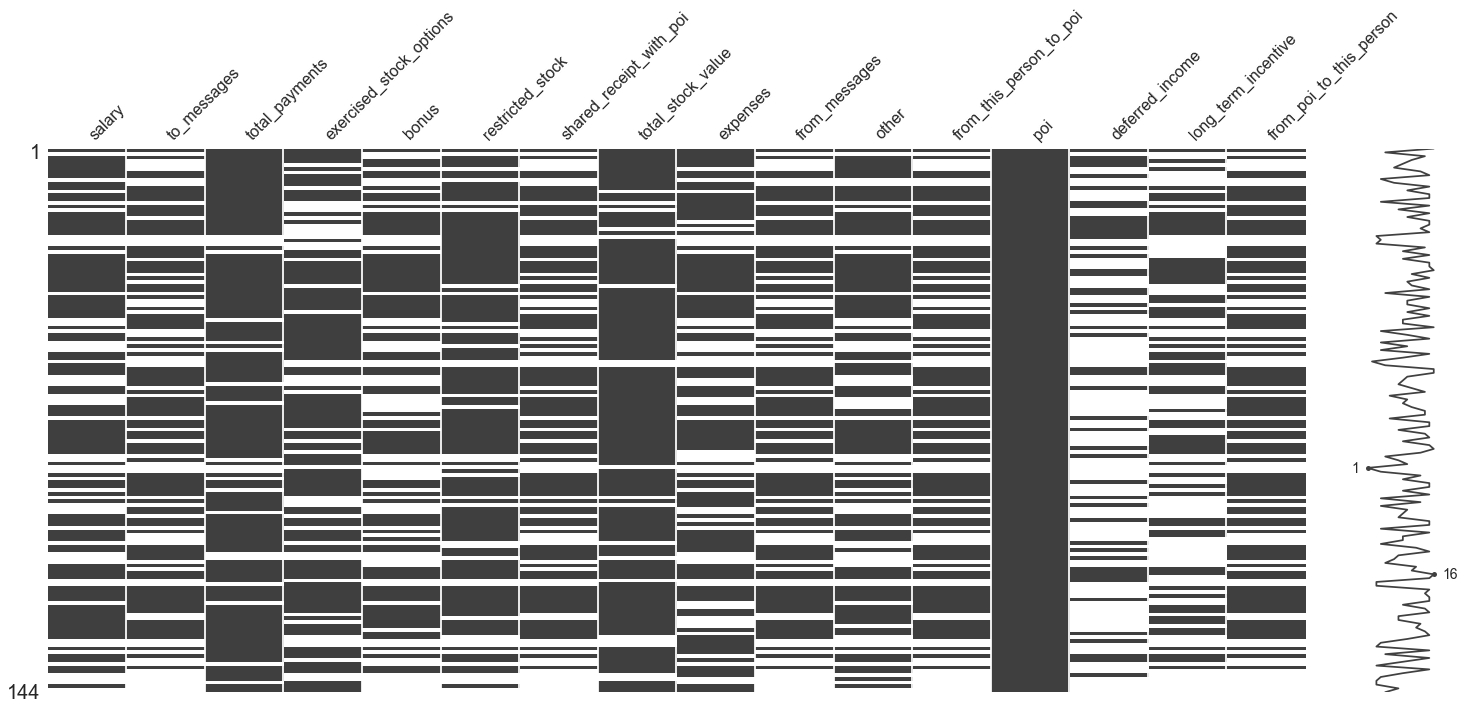

In [84]:
# visualize missing data
msno.matrix(data_df)

Missing values are displayed as white boxes in the missing data matrix. The missingness shows no obvious pattern for any feature (e.g. ). 
Since the data was collected on basis of a federal investigation, we can furthermore assume that employees were not allowed to hold back or delete any data. This also supports the notion that missingness is rather random than biased.

Furthermore, lets assess the occurence of outliers for each feature by plotting the data. Removal of potential outliers will make sure that no bias is introduced during imputation. Boxplots for each feature, comparing values for "poi" and "Regular", will provide a good overview of the underlying data distribution.   

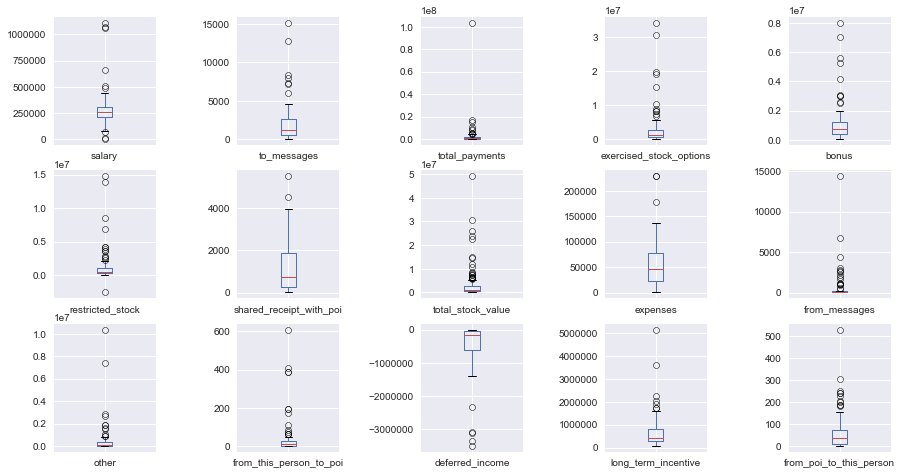

In [782]:
# manualy override the matplotlib configuration file to display outliers (in default mode outliers are not displayed)
plt.rc("lines", markeredgewidth=0.5)

data_df.drop(["poi"], axis=1).plot(kind="box", subplots=True, layout=(3,5), figsize = (15,8))
plt.subplots_adjust(wspace=0.8)

Now, let's compare the distribution of each feature for "person of interest" versus "regular person". This will provide an overview about the discriminative power of each feature. Based on this assessment, we can decide whether features can be excluded, thus, decreasing model complexity.

Basically, all features exhibit values that qualify as outliers in terms of the technical definition, which is as follows:

outlier lower end Q1 – 1.5×IQR  
outlier upper end Q3 + 1.5×IQR  

IQR = interquartile range  
Q1 = 25% quartile  
Q3 = 25% quartile  

E.g., for salary, some data points are well above \$1000000. Nevertheless, those outliers might actually reflect true values. E.g., we can assume that all data representing payments and stock values, is having disproportionally higher values for the top executives (e.g., Ken Lay, Jeffrey Skilling, etc.) as opposed for regular employees!! 

There are also values that might qualify as outliers for from_messages (e.g., > 14000 messages!!) and from_this_person_to_poi (e.g., >600 messages). With respect to these features describing email communication (from_messages, from_this_person_to_poi, from_poi_to_this_person), I have no robust expectations about reasonable nubmers of emails, etc. However, I will make the assumption that only top executives are supposed to have such high numbers. I reason that communication is a key task for major representatives of a company (even more than for regular employees), which also involves communication via email. 

Overall, one has to be very careful about defining a threshold that separates outlieres, because as already mentioned, we can expect a discrepancy in values by many orders of magnitude between regular employees, middle/upper management and top executives for features associated with financial data. 

In [12]:
data_df["salary"].quantile([0.1,0.25,0.5])

0.10    159715.8
0.25    211802.0
0.50    258741.0
Name: salary, dtype: float64

The 25% percentile and median are well above \$200,000 and even the 10% percentile is above \$150,000. If we assume $100,000 as the average salary for upper management positions (http://work.chron.com/salaries-upperlevel-management-1899.html) then the dataset contains almost exclusively upper/top management employees! As such, outliers in the upper range are likely possible to be valid and we don't have enough information to decide otherwise, respectively.

Nevertheless, there are a few values that still don't seem to fit in the valid range, as we defined it.  
These are:  
1. salary value close to 0 
2. total_payments value >100 million
3. restricted stock value <0

*Research employees with lowest salaries*

In [13]:
# filter employees by salary < $100000
data_df["salary"][data_df["salary"] < 100000]

BANNANTINE JAMES M      477.0
BAZELIDES PHILIP J    80818.0
GRAY RODNEY            6615.0
IZZO LAWRENCE L       85274.0
OVERDYKE JR JERE C    94941.0
REDMOND BRIAN L       96840.0
REYNOLDS LAWRENCE     76399.0
WESTFAHL RICHARD K    63744.0
Name: salary, dtype: float64

The salaries of BANNANTINE JAMES M and GRAY RODNEY exhibit a stark deviation from the median salary (approx. 250000) and can't be actually considered as valid annual salaries. Let's try to shed some light by having a closer look at the CV's of Mr. Bannantine and Mr. Gray.


**BANNANTINE JAMES M**  
from http://shopops1.com/james-m-bannantine/:

*"Mr. Bannantine worked with Enron Corporation for ten years, from 1990 to 2000, holding several top management positions, including Chief Executive Officer for Enron South America, a $1.5 billion power and pipeline division of Enron."*  

Clearly, Mr. Bannantine belongs to the top management staff members. However, he was affiliated with enron's subsidiary in South America. It seems that his true salary is not listed in the documents. Maybe this is due to some accounting specifications (formality), because he was not directly affiliated with the main branch (receiving the salary from the subsidiary). This is supported by the finding that he received substantial payments for consulting service (original pdf file).

**GRAY RODNEY**  
from https://www.bloomberg.com/research/stocks/private/person.asp?personId=438862&privcapId=337480:  

*"Mr. Gray served as Chief Executive Officer of Enron Global Power & Pipelines LLC from October 1994 to 1997 and its Chairman from June 1995 to 1997. Mr. Gray served as Executive Vice President of Enron International Inc. ('EI') and has served as a Managing Director of both EDC and of Enron Capital & Trade Resources Corp. ('ECT'). Mr. Gray joined Enron Corp. in 1988 as Vice President and Treasurer."*

Enron Global Power & Pipelines LLC was another subsidiary. Similarly to Mr. Bannantine, Mr. Gray was a top executive and we can expect a much higher salary. Again, because of his affiliation to a subsidiary of enron, there is a possibility that his financial compensation was documented in enron's account books primarily by means of consulting services ($680833 based on information from the original pdf).  

Nevertheless, I expect both, Mr Gray and Mr Bannantine, to have received a regular CEO salary from their respective companies. I will substitute both values with the median salary.

In [14]:
salary_median = np.median(data_df["salary"].dropna())

data_df["salary"].loc["BANNANTINE JAMES M"] = salary_median
data_df["salary"].loc["GRAY RODNEY"] = salary_median

Confirmation of successful substitution

In [15]:
print data_df["salary"].loc["BANNANTINE JAMES M"]
print data_df["salary"].loc["GRAY RODNEY"]

258741.0
258741.0


*research the single employee with \>$100 million total payment*

In [16]:
data_df["total_payments"][data_df["total_payments"] > 1e8]

LAY KENNETH L    103559793.0
Name: total_payments, dtype: float64

As founder and former Enron CEO, Kenneth Lay may well have received this sum. But lets confirm this by summing over all financial features corresponding to Kenneth Lay and see if the sum matches the total payments value. Deviation from the total payments value would be indicative of an error/typo in the course of setting up the dataset.

**It is required to reload the default main dataset, because we already removed some features, which are required for correctly facilitating the audit.**

In [17]:
# load the original dataset, because some features have been removed
financial_features = ["salary", "bonus", "expenses", "other", "deferred_income", "long_term_incentive",
                     "deferral_payments", "loan_advances", "director_fees"]

complete_data = pd.DataFrame.from_dict(financial_data, orient = "index")
complete_data.replace("NaN", np.nan, inplace = True)

sum(complete_data[financial_features].loc["LAY KENNETH L"].dropna())

103559793.0

The sum over all financial features matches the total payment value. I will compare the total payments value with the sum of all financial featuresfor all employees.

In [18]:
complete_data.apply(lambda row: sum(row[financial_features].dropna()) == row["total_payments"], axis=1).value_counts()

True     123
False     23
dtype: int64

23 employees exhibit a mismatch between total payments and the sum of all financial features. However, False will also be returned if the value for total payments is NaN. So let's extract only those employees having a mismatch and not NaN as total payments value. Subtraction of total payments value from the sum of financial features yields value < 0 only in case of a mismatch.

In [19]:
mismatch = complete_data.apply(lambda row: sum(row[financial_features].dropna()) - row["total_payments"], axis=1).dropna()

mismatch[mismatch != 0]

BELFER ROBERT        -201715.0
BHATNAGAR SANJAY   -15180562.0
dtype: float64

In [20]:
print complete_data.loc["BHATNAGAR SANJAY"]["total_payments"]
print complete_data.loc["BELFER ROBERT"]["total_payments"]

15456290.0
102500.0


These two employees exhibit a true mismatch between their respective total payments value versus the sum of all financial features. Looking up these two entries in original pdf file, it seems that the mismatch is due to column swap (director fees instead of total payments for Belfer Robert; Expected stock options instead of total payments for Bhatnagar Sanjay).
The wrong entries will be replaced by the sum of the financial features respectively. 

In [21]:
data_df["total_payments"].loc["BHATNAGAR SANJAY"] = sum(complete_data.loc["BHATNAGAR SANJAY"][financial_features].replace(np.nan,0))
data_df["total_payments"].loc["BELFER ROBERT"] = sum(complete_data.loc["BELFER ROBERT"][financial_features].replace(np.nan,0))

In [22]:
print data_df["total_payments"].loc["BHATNAGAR SANJAY"]
print data_df["total_payments"].loc["BELFER ROBERT"]

275728.0
-99215.0


Why is the new total payments value for Belfer Robert negative?

In [23]:
complete_data[financial_features].loc["BELFER ROBERT"].replace(np.nan,0)

salary                      0.0
bonus                       0.0
expenses                    0.0
other                       0.0
deferred_income             0.0
long_term_incentive         0.0
deferral_payments     -102500.0
loan_advances               0.0
director_fees            3285.0
Name: BELFER ROBERT, dtype: float64

The reason is that the corresponding value for deferral_payments is negative, but we know from the sneak peak at the dataset (section Check for irregularities and outliers) that deferral_payments have positive values. Let's check if employees other than Robert Belfer also have negative values as their corresponding deferral_payments values.  

In [24]:
complete_data["deferral_payments"][complete_data["deferral_payments"] < 0]

BELFER ROBERT   -102500.0
Name: deferral_payments, dtype: float64

This is only true for Robert Belfer. I conclude that the negative value is a mistake/typo and will be transformed to a positive value.

In [25]:
complete_data["deferral_payments"].loc["BELFER ROBERT"] = 102500

Confirmation of successful substitution

In [26]:
complete_data["deferral_payments"].loc["BELFER ROBERT"]

102500.0

Let's update the total payments value in the dataset that will be used throughout the project (data_df). 

In [27]:
data_df["total_payments"].loc["BELFER ROBERT"] = sum(complete_data.loc["BELFER ROBERT"][financial_features].replace(np.nan,0))

Confirmation of successful substitution

In [28]:
print data_df["total_payments"].loc["BELFER ROBERT"]

105785.0


*Research the single value <0 in restricted stock*

In [29]:
data_df["restricted_stock"][data_df["restricted_stock"] < 0]

BHATNAGAR SANJAY   -2604490.0
Name: restricted_stock, dtype: float64

Interestingly, the negative value corresponds to Bhatnagar Sanjay, who already had a negative value in the total_payments feature. This might indicate that all feature values for Bhatnagar Sanjay are erroneously negative.

In [30]:
data_df.loc["BHATNAGAR SANJAY"]

salary                             NaN
to_messages                        523
total_payments                  275728
exercised_stock_options    2.60449e+06
bonus                              NaN
restricted_stock          -2.60449e+06
shared_receipt_with_poi            463
total_stock_value                  NaN
expenses                           NaN
from_messages                       29
other                           137864
from_this_person_to_poi              1
poi                              False
deferred_income                    NaN
long_term_incentive                NaN
from_poi_to_this_person              0
Name: BHATNAGAR SANJAY, dtype: object

It appears that only the restricted stock feature has a negative value (we fixed total_payments). It will be transformed to a positive value. 

In [31]:
data_df["restricted_stock"].loc["BHATNAGAR SANJAY"] = 2.60449e+06

Confirmation of successful substitution

In [32]:
data_df["restricted_stock"].loc["BHATNAGAR SANJAY"]

2604490.0

Since we discovered multiple values having a negative value but we expect a positive value, let's check if any of the other features contain negative values (excluding deferred_income)

In [33]:
data_df.apply(lambda row: any(row < 0))

salary                     False
to_messages                False
total_payments             False
exercised_stock_options    False
bonus                      False
restricted_stock           False
shared_receipt_with_poi    False
total_stock_value           True
expenses                   False
from_messages              False
other                      False
from_this_person_to_poi    False
poi                        False
deferred_income             True
long_term_incentive        False
from_poi_to_this_person    False
dtype: bool

Now, let's examine how many data points have a negative total_stock value.

In [34]:
data_df["total_stock_value"][data_df["total_stock_value"] < 0]

BELFER ROBERT   -44093.0
Name: total_stock_value, dtype: float64

This is true for only one employee. Negative values have already been identified for Robert Belfer (see section above). This implies a systemic mistake (all negative entries) in the course of setting up the dataset. The total_stock value will be transformed into a positive value. 

In [35]:
data_df["total_stock_value"].loc["BELFER ROBERT"] = 44093.0

Confirming the correction of the total_stock_value value for Robert Belfer

In [36]:
data_df["total_stock_value"].loc["BELFER ROBERT"]

44093.0

# Imputation

I will make following assumption for the imputation procedure:  

   1. The correlation matrix below indicates a weak correlation between data describing email communication and financial data. Strongest correlation can be observed between features related to financial data and features related to email communication, respectively. Good correlation is beneficial for imputation, because we don't care about causal relationship between those variables, but simply want accurate predictions. Therefore, imputation will be conducted separately for financial features and email features, respectively, each grouped by by the poi feature.  
   

   2. Financial data (features describing payments and stocks) is expected to have a value. E.g., salary is mandatory for employees and it makes no sense for salary to be of 0 value. Furthermore, I expect all other features related to financial data to have a value > 0 (with the exception of deferred income -negative values-).  
   

   3. Recall that the initial analysis of missing values exposed NaN in email features. From the histogram in the figure below, we can see that email features also contain 0 values. Having a closer look at email features, it seems that NaN are representative of completely missing employees, whereas 0 is used if only certain email features are missing but at least one email feature is present for a given employee. Here, 0 values are considered as true values and will not be imputed.   

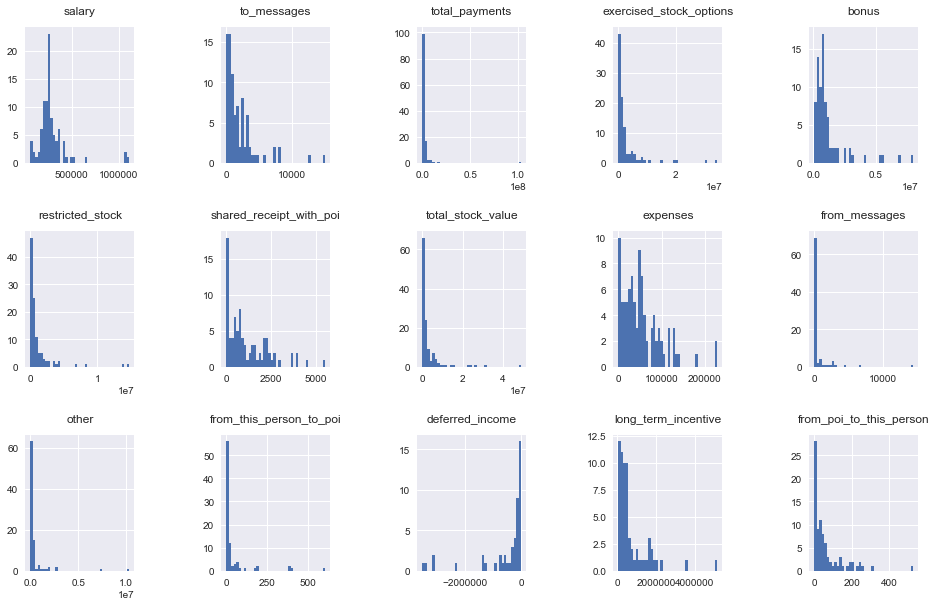

In [48]:
# arrange all features (except poi) in 3 lists, each list containing 5 features. 
#--> 3x5 will be the shape of the figure
feature_list = np.array(data_df.columns.drop(["poi"])).reshape(3,5)

# create figure object with 15 subplots (3x5 arrangement)
fig, axes = plt.subplots(3,5, sharex=False, sharey=False, figsize=(16,10))
for i in range(3):
    for j in range(5):
        # extract each feature from the main dataframe and group by "poi" 
        feature = data_df[feature_list[i][j]].dropna()
        
        # plot histogram
        axes[i,j].hist(feature.values, bins = 40)
        axes[i,j].set_title(feature_list[i][j]).set_position([.5, 1.05])
        
plt.subplots_adjust(wspace=0.8, hspace=0.5)  

In [809]:
data_df.corr()

,salary,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,deferred_income,long_term_incentive,from_poi_to_this_person
salary,1.000000,0.177177,0.589283,0.619883,0.523190,0.562643,0.274921,0.627087,0.147909,-0.010733,0.632684,0.012152,0.257609,-0.338275,0.483622,0.173847
to_messages,0.177177,1.000000,0.145492,0.079568,0.372997,0.176318,0.847990,0.120864,0.155070,0.475450,0.040580,0.568506,0.058954,-0.350815,0.134277,0.525667
total_payments,0.589283,0.145492,1.000000,0.597378,0.569054,0.626164,0.203986,0.668176,0.109798,-0.027616,0.834537,0.018946,0.237214,-0.054404,0.518498,0.168825
exercised_stock_options,0.619883,0.079568,0.597378,1.000000,0.506998,0.697974,0.154333,0.963561,0.019412,-0.066129,0.536248,-0.030101,0.503551,-0.308076,0.500016,0.160253
bonus,0.523190,0.372997,0.569054,0.506998,1.000000,0.376992,0.549102,0.509441,0.033799,0.052725,0.376371,0.354634,0.302384,-0.411659,0.625259,0.562187
restricted_stock,0.562643,0.176318,0.626164,0.697974,0.376992,1.000000,0.212713,0.855250,0.042896,-0.008696,0.647534,0.034975,0.218089,-0.133895,0.635172,0.107548
shared_receipt_with_poi,0.274921,0.847990,0.203986,0.154333,0.549102,0.212713,1.000000,0.176314,0.223495,0.230855,0.122591,0.475748,0.228313,-0.394677,0.178944,0.659264
total_stock_value,0.627087,0.120864,0.668176,0.963561,0.509441,0.855250,0.176314,1.000000,0.034707,-0.036310,0.627171,0.001289,0.366438,-0.298189,0.495485,0.146366
expenses,0.147909,0.155070,0.109798,0.019412,0.033799,0.042896,0.223495,0.034707,1.000000,0.094144,0.062874,0.014964,0.060292,0.101181,-0.100766,-0.059244
from_messages,-0.010733,0.475450,-0.027616,-0.066129,0.052725,-0.008696,0.230855,-0.036310,0.094144,1.000000,-0.101686,0.588687,-0.074308,-0.319995,-0.071958,0.186708


Split the dataset into subsets by poi and drop the poi feature (no relevant information for imputation). Imputation will be conducted separately for each group.   

In [37]:
poiYes_data = data_df[data_df["poi"] == True]
poiNo_data = data_df[data_df["poi"] == False]

I decided to apply multiple imputation on missing data, because the proportion of missing data is very high for each feature. Consequently, single imputation (e.g., mean, median) would introduce a bias and strongly underestimate variance. This in turn would lead to compromised relationship between features and, thus, strongly bias model accuracy. (wrong inference because more data points assumed than actually available). Let's start with imputing missing values for financial features. 

In [39]:
# all email features 
email_features = set(["to_messages", "shared_receipt_with_poi", "from_messages", 
                "from_this_person_to_poi", "from_poi_to_this_person"])

# all financial status-relevant features including the feature for poi
financial_features = set(data_df.columns) - email_features
financial_features.remove("poi")

poi_data_filled = MICE(n_imputations=500, verbose=False).complete(np.array(poiYes_data[list(financial_features)]))
poi_data_filled = pd.DataFrame(poi_data_filled)
#use indices to reconstruct the dataframe after imputation
poi_data_filled.index = poiYes_data.index

poi_data_filled.columns = poiYes_data[list(financial_features)].columns
poi_data_filled.head(5)

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,deferred_income,restricted_stock,long_term_incentive
BELDEN TIMOTHY N,213999.0,5501630.0,5249999.0,1110705.0,17355.0,9.531360e+05,210698.0,-2334434.0,157569.0,1.231696e+06
BOWEN JR RAYMOND M,278601.0,2669589.0,1350000.0,252055.0,65907.0,-2.503382e+05,1621.0,-833.0,252055.0,9.742930e+05
CALGER CHRISTOPHER F,240189.0,1639297.0,1250000.0,126027.0,35818.0,-2.078368e+05,486.0,-262500.0,126027.0,3.753040e+05
CAUSEY RICHARD A,415189.0,1868758.0,1000000.0,2502063.0,30674.0,1.313194e+06,307895.0,-235000.0,2502063.0,3.500000e+05
COLWELL WESLEY,288542.0,1490344.0,1200000.0,698242.0,16514.0,-5.494003e+04,101740.0,-144062.0,698242.0,7.692522e+05


Imputation results in negative values for exercised stock options. This might be due to the skewed distribution in each features. As evident from the histogram series in the figure below, the distribution in each feature approaches normal distribution following log10 transformation.

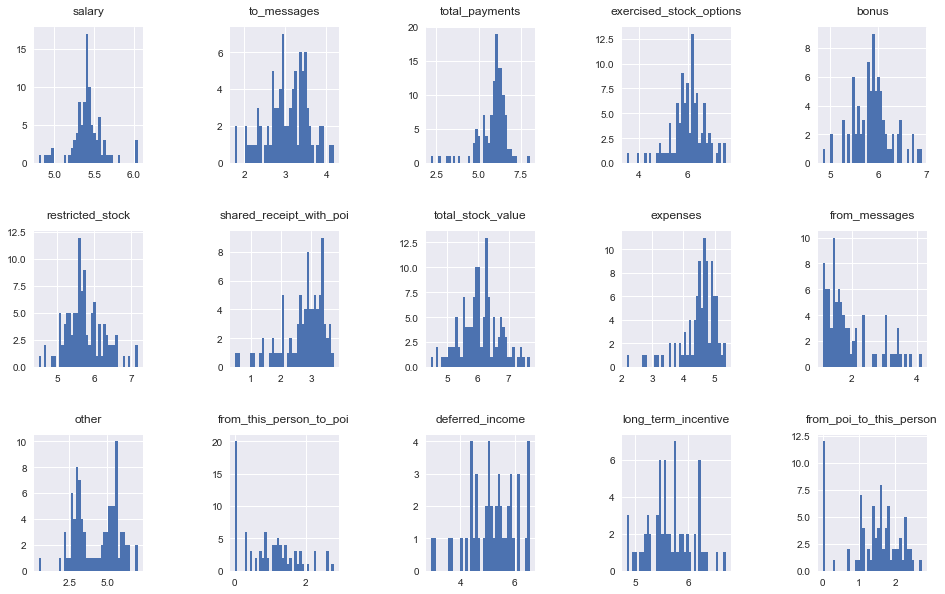

In [1429]:
# create figure object with 15 subplots (3x5 arrangement)
fig, axes = plt.subplots(3,5, sharex=False, sharey=False, figsize=(16,10))
for i in range(3):
    for j in range(5):
        try:
            # extract each feature from the main dataframe and group by "poi" 
            feature = data_df[feature_list[i][j]].dropna()
            # transform 0 to non-zero values to allow log10 transformation
            feature = feature+1
            # convert deferred income to positive values to allow log10 transformation
            if feature_list[i][j] == "deferred_income":
                feature *= -1 
            # plot histogram
            axes[i,j].hist(np.log10(feature.values), bins = 40)
            axes[i,j].set_title(feature_list[i][j]).set_position([.5, 1.05])
        except IndexError:
            continue
plt.subplots_adjust(wspace=0.8, hspace=0.5)  

Let's repeat imputation, however, using log10 scale for each feature. After imputation, features will be transformed to linear scale. 
(*use MultipleImputation function from imputation.py)*

In [97]:
from imputation import MultipleImputation

financial_features_poi_imputed = MultipleImputation(poiYes_data, financial_features)
email_features_poi_imputed = MultipleImputation(poiYes_data,  email_features)

poi_data_filled = pd.merge(financial_features_poi_imputed, email_features_poi_imputed, left_index=True, right_index=True)
poi_data_filled["poi"] = data_df["poi"]
poi_data_filled.tail(5)

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,deferred_income,restricted_stock,long_term_incentive,from_poi_to_this_person,to_messages,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
RICE KENNETH D,420636.0,505050.0,1.750000e+06,22542539.0,46950.0,19794175.0,174839.0,-3.504386e+06,2748364.0,1.617011e+06,42.000000,905.000000,18.000000,4.000000,864.000000,True
RIEKER PAULA H,249201.0,1099100.0,7.000000e+05,1918887.0,33271.0,1635238.0,1950.0,-1.000000e+05,283649.0,7.596885e+05,35.000000,1328.000000,82.000000,48.000000,1258.000000,True
SHELBY REX,211844.0,2003885.0,2.000000e+05,2493616.0,22884.0,1624396.0,1573324.0,-4.167000e+03,869220.0,4.569229e+05,13.000000,225.000000,39.000000,14.000000,91.000000,True
SKILLING JEFFREY K,1111258.0,8682716.0,5.600000e+06,26093672.0,29336.0,19250000.0,22122.0,-5.738706e+05,6843672.0,1.920000e+06,88.000000,3627.000000,108.000000,30.000000,2042.000000,True
YEAGER F SCOTT,158403.0,360300.0,1.178640e+06,11884758.0,53947.0,8308552.0,147950.0,-9.604029e+05,3576206.0,9.905317e+05,73.562195,1713.589655,76.365948,23.628642,1243.347989,True


Following transformation to log10 scale, multiple imputation returns reasonable (positive) values for excercised stock options. So let's apply the same imputation strategy to data related to regular employees (not poi).

*before imputation of non-poi values*

In [98]:
data_df[data_df["poi"] == False].head(5)

,salary,to_messages,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,total_stock_value,expenses,from_messages,other,from_this_person_to_poi,poi,deferred_income,long_term_incentive,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,1729541.0,13868.0,2195.0,152.0,65.0,False,-3081055.0,304805.0,47.0
BADUM JAMES P,NaN,NaN,182466.0,257817.0,NaN,NaN,NaN,257817.0,3486.0,NaN,NaN,NaN,False,NaN,NaN,NaN
BANNANTINE JAMES M,258741.0,566.0,916197.0,4046157.0,NaN,1757552.0,465.0,5243487.0,56301.0,29.0,864523.0,0.0,False,-5104.0,NaN,39.0
BAXTER JOHN C,267102.0,NaN,5634343.0,6680544.0,1200000.0,3942714.0,NaN,10623258.0,11200.0,NaN,2660303.0,NaN,False,-1386055.0,1586055.0,NaN
BAY FRANKLIN R,239671.0,NaN,827696.0,NaN,400000.0,145796.0,NaN,63014.0,129142.0,NaN,69.0,NaN,False,-201641.0,NaN,NaN


*after imputation of non-poi values*

In [99]:
financial_features_not_poi_imputed = MultipleImputation(poiNo_data, financial_features)
email_features_not_poi_imputed = MultipleImputation(poiNo_data, email_features)

not_poi_data_filled = pd.merge(financial_features_not_poi_imputed, email_features_not_poi_imputed, left_index=True, right_index=True)
not_poi_data_filled["poi"] = data_df["poi"]
not_poi_data_filled.head(5)

,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,deferred_income,restricted_stock,long_term_incentive,from_poi_to_this_person,to_messages,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
ALLEN PHILLIP K,201955.00000,4484442.0,4.175000e+06,1729541.0,13868.0,1.729541e+06,1.520000e+02,-3.081055e+06,1.260270e+05,3.048050e+05,47.000000,2902.000000,2195.000000,65.000000,1407.000000,False
BADUM JAMES P,186960.85553,182466.0,3.161551e+05,257817.0,3486.0,2.578170e+05,4.107662e+03,-8.302308e+04,2.497844e+05,2.140665e+05,18.954550,1004.775337,79.562761,6.274474,441.660188,False
BANNANTINE JAMES M,258741.00000,916197.0,6.704782e+05,5243487.0,56301.0,4.046157e+06,8.645230e+05,-5.104000e+03,1.757552e+06,3.821881e+05,39.000000,566.000000,29.000000,0.000000,465.000000,False
BAXTER JOHN C,267102.00000,5634343.0,1.200000e+06,10623258.0,11200.0,6.680544e+06,2.660303e+06,-1.386055e+06,3.942714e+06,1.586055e+06,20.400568,1019.726056,69.098637,5.588987,468.715836,False
BAY FRANKLIN R,239671.00000,827696.0,4.000000e+05,63014.0,129142.0,1.663380e+05,6.900000e+01,-2.016410e+05,1.457960e+05,2.415097e+05,18.597281,963.534609,85.987848,6.512549,396.985983,False


The non-poi subset values are as expected following the aforementioned imputation technique. Imputation of missing values in email features results in float estimates (technically not possible), which however, is irrelevant in downstream analysis and will  be ignored.  

Following Imputation, combine email and financial subsets back into one dataframe.

In [100]:
data_df = pd.concat([poi_data_filled, not_poi_data_filled], axis=0)

In [101]:
print "BEFORE IMPUTATION"
print "\n"
print poiNo_data.loc["BADUM JAMES P"]
print "\n\n"
print "AFTER COMPLETE IMPUTATION"
print "\n"
print data_df.loc["BADUM JAMES P"]

BEFORE IMPUTATION


salary                        NaN
to_messages                   NaN
total_payments             182466
exercised_stock_options    257817
bonus                         NaN
restricted_stock              NaN
shared_receipt_with_poi       NaN
total_stock_value          257817
expenses                     3486
from_messages                 NaN
other                         NaN
from_this_person_to_poi       NaN
poi                         False
deferred_income               NaN
long_term_incentive           NaN
from_poi_to_this_person       NaN
Name: BADUM JAMES P, dtype: object



AFTER COMPLETE IMPUTATION


salary                      186961
total_payments              182466
bonus                       316155
total_stock_value           257817
expenses                      3486
exercised_stock_options     257817
other                      4107.66
deferred_income           -83023.1
restricted_stock            249784
long_term_incentive         214067
from_poi_to_this_per

Comparing a data point ("BADUM JAMES P") before and after final imputation confirms the validity of the remerged dataset, which is to be used in downstream steps. 

Shuffling the merged dataset, which lists all poi-class employees followed by non-poi-class employees, is recommended to avoid any bias in downstream data processing.

In [102]:
print "BEFORE SHUFFELING"
data_df.head(5)

BEFORE SHUFFELING


,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,deferred_income,restricted_stock,long_term_incentive,from_poi_to_this_person,to_messages,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
BELDEN TIMOTHY N,213999.0,5501630.0,5249999.0,1110705.0,17355.0,9.531360e+05,210698.0,-2334434.0,157569.0,600758.882273,228.0,7991.0,484.0,108.0,5521.0,True
BOWEN JR RAYMOND M,278601.0,2669589.0,1350000.0,252055.0,65907.0,6.243031e+05,1621.0,-833.0,252055.0,974293.000000,140.0,1858.0,27.0,15.0,1593.0,True
CALGER CHRISTOPHER F,240189.0,1639297.0,1250000.0,126027.0,35818.0,5.454893e+05,486.0,-262500.0,126027.0,375304.000000,199.0,2598.0,144.0,25.0,2188.0,True
CAUSEY RICHARD A,415189.0,1868758.0,1000000.0,2502063.0,30674.0,3.501988e+06,307895.0,-235000.0,2502063.0,350000.000000,58.0,1892.0,49.0,12.0,1585.0,True
COLWELL WESLEY,288542.0,1490344.0,1200000.0,698242.0,16514.0,1.613226e+06,101740.0,-144062.0,698242.0,682350.681114,240.0,1758.0,40.0,11.0,1132.0,True


In [103]:
print "AFTER SHUFFELING"
data_df = data_df.sample(frac=1)
data_df.head(5)

AFTER SHUFFELING


,salary,total_payments,bonus,total_stock_value,expenses,exercised_stock_options,other,deferred_income,restricted_stock,long_term_incentive,from_poi_to_this_person,to_messages,from_messages,from_this_person_to_poi,shared_receipt_with_poi,poi
BIBI PHILIPPE A,213625.000000,2.047593e+06,1.000000e+06,1.843816e+06,38559.000000,1.465734e+06,425688.000000,-186991.065713,3.780820e+05,369721.000000,23.000000,1607.000000,40.000000,8.000000,1336.000000,False
FALLON JAMES B,304588.000000,3.676340e+06,2.500000e+06,2.332399e+06,95924.000000,9.402570e+05,401481.000000,-172891.626153,1.392142e+06,374347.000000,42.000000,1755.000000,75.000000,37.000000,1604.000000,False
MEYER JEROME J,125535.965430,2.151000e+03,1.040278e+05,3.235032e+05,2151.000000,2.515871e+05,1704.542918,-38346.000000,2.120370e+05,77729.218879,26.703202,1282.439842,113.152159,9.230237,635.130575,False
CLINE KENNETH W,225723.265037,3.680254e+05,4.290120e+05,1.895180e+05,24503.780745,3.094344e+05,9779.410974,-88719.066040,6.620860e+05,250580.322067,24.207282,1065.713961,88.147552,7.466978,495.434029,False
BANNANTINE JAMES M,258741.000000,9.161970e+05,6.704782e+05,5.243487e+06,56301.000000,4.046157e+06,864523.000000,-5104.000000,1.757552e+06,382188.140339,39.000000,566.000000,29.000000,0.000000,465.000000,False


pickle the imputed main dataset

In [104]:
with open("data_df_filtered_imputed.pkl", "wb") as file_out:
    pickle.dump(data_df, file_out) 

load filtered and imputed main dataset if necessary

In [5]:
with open("data_df_filtered_imputed.pkl", "r") as file_in:
    data_df = pickle.load(file_in) 

# Extracting paths to employee emails 
Email paths will be used to assess and analyse the email correspondence for each employee from the main dataset, which will be required for engineering of novel features.

##### Extracting all available email addresses for each employee 
Multiple valid email addresses (obtained via execution of poiEmails()) are associated with poi employees, however, the main dataset (data_df or complete_df) is listing only one address each. In order to be sure that all poi emails can be identified within the email corpus, a dictionary will be created to store all available poi email addresses (dict key) by the correponding poi name (dict value). Furthermore, this dictionary will be expanded by non-poi email addresses to record all available email addresses for all enron employees present in the main dataset (data_df or complete_df). As such, the email address dictionary will serve as a reference to verify if any email has been written by an enron employee present in the main dataset. 

*(use EmailPaths() in email_paths.py and poiEmails() in poi_email_addresses.py)*

In [38]:
# import function poiEmails() that returns all email addresses for poi employees
from poi_email_addresses import poiEmails
from email_paths import *

# path to directory that contains the email dataset; for each employee there is a separate subdirectory within root
# root path depends on where the user has saved the email corpus on his harddrive!!
root = "/Users/damirvana/Coursera_EDX/UDACITY_Data_Analyst_Nanodegree/P5_Machine_Learning/maildir"
email_processor = EmailPaths(root)
poi_emails = poiEmails()
email_by_name = email_processor.EmployeeEmails(poi_emails, default_dataset)

In [42]:
sorted(email_by_name.items())[:10]

[("'bowen@enron.com", 'BOWEN JR RAYMOND M'),
 ("'david.delainey'@enron.com", 'DELAINEY DAVID W'),
 ("'delainey@enron.com", 'DELAINEY DAVID W'),
 ('NaN', 'BADUM JAMES P'),
 ('a..martin@enron.com', 'MARTIN AMANDA K'),
 ('adam.umanoff@enron.com', 'UMANOFF ADAM S'),
 ('andrew.fastow@enron.com', 'FASTOW ANDREW S'),
 ('andrew.s.fastow@enron.com', 'FASTOW ANDREW S'),
 ('andy.fastow@enron.com', 'FASTOW ANDREW S'),
 ("ben'.'glisan@enron.com", 'GLISAN JR BEN F')]

The dictionary storing all emails seems to be of expected structure. However, NaN as an email address for BADUM JAMES P needs to be removed. 
- multiple email addresses for single employees 
- email address pointing to cognate employee name

In [8]:
email_by_name.pop("NaN")

'BADUM JAMES P'

##### Extracting file paths specifying emails written by each employee
The path of each email that has been authored by any of the enron employees present in the main dataset will be extracted. For each employee, a key:value entry will be defined within a dictionary. The employee's name will be assigned as the key, whereas a list storing all email paths for that particular employee will be assigned as the cognate value.

Expected data structure:  
*{name1:[path1, path2], name2:[path1, path2], ...}*

The best approach would be to survey only all sent emails for each employee, because this would ignore duplicated emails. However, the email corpus doesn't contain a separate folder for each employee (e.g., folder for FASTOW ANDREW is not present). Nevertheless, the dataset contains emails sent by those missing employees, which are stored in subfolders of other employees. Therefore, I decided to include all emails to extract paths instead of only sent emails (this would only encompass 23 employees). 

*(use ExtractPath() in email_paths.py; requires RemoveMetaData(), ExtractEmailAdress(), IdentifyEmailAddress() which can also be found in email_paths.py)*

In [9]:
from_email_paths = email_processor.extractPath(email_by_name)
#from_email_paths = ExtractPath(root, email_by_name)

In [247]:
from_email_paths

defaultdict(list,
            {'ALLEN PHILLIP K': ['/Users/damirvana/Coursera_EDX/UDACITY_Data_Analyst_Nanodegree/P5_Machine_Learning/maildir_test_copy/allen-p/sent/1.',
              '/Users/damirvana/Coursera_EDX/UDACITY_Data_Analyst_Nanodegree/P5_Machine_Learning/maildir_test_copy/allen-p/sent/2.',
              '/Users/damirvana/Coursera_EDX/UDACITY_Data_Analyst_Nanodegree/P5_Machine_Learning/maildir_test_copy/allen-p/sent/3.']})

Using a small subset of the email corpus confirms that the dictionary is of appropriate structure and contains all emails written by a particular employee.
Now we can use the entire corpus, run the code and save the dictionary using pickle (this will preserve the data structure). This file will be used to access all emails in the course of applying natural language techniques.

Pickle the dictionary with email paths

In [188]:
with open("from_email_paths.pkl", "wb") as file_out:
    pickle.dump(from_email_paths, file_out)

If required load the dictionary containing extracted email paths from the entire email corpus.

In [9]:
with open("from_email_paths.pkl", "r") as file_in:
    from_email_paths = pickle.load(file_in)

# Creating new features
#### Difference in frequency of sent/received emails as  a new feature

On august 15, 2001 Kenneth Lay was informed by Sherron Watkins about accounting issues. If a significant amount of communication between employees was carried out via email, I hypothesize that there is a difference in the number of emails sent/received for poi employees as opposed to non-poi employees.  

##### two possible scenarios
*more email communication after august 15, 2001*  
Assuming poi employees feeling caught in the act of commiting fraud as Sherron Watkins became suspicious, a state of panic is triggered. Or alternatively, poi employees feeling required to come up with a new plan on how to handle the situation. In either case, the communication between poi employees increases.


*less email communication after august 15, 2001*  
In this scenario, I assume poi employees going into "stealth" mode trying to reduce the possibility that any relevant information about the participation will be leaked. Consequently, communication via email is reduced.


August 15, 2001 will be used as the reference date. For each employee the number of emails sent/received (to/by poi) before and after the reference date will be calculated. The email counts will be normalized to total email count and the normalized frequency change will be obtained by dividing counts after the reference date by counts before the reference date. E.g., if 10 out of 100 and 40 out of 200 emails were sent to poi before and after the reference date, respectively, it will result in a frequency change of 2. This means that 2 times more emails were sent to poi after the reference date. Furthermore, I decided to weight the emails with respect to the type of email recipients. If recipients are exclusively poi, the email will be weighted by a factor of 10, whereas emails with mixed groups of recipients (poi and none poi) will be weighted a factor of 1.
The reasoning behind weighting is that first, I assume a person of interest will send more emails to another person of interest and second, if another poi (or a group of poi) is the only recipient, it is more likely that the content of this email conversation is about the fraudulent activity. It is less likely that email communication with mixed recipients (poi and none poi) will include content in the context of the fraudulent activity.



##### Discrepancy in email sent/received counts between datasets
The function EmailFrequencyChange was used to retrieve the aforementioned ratios. In order to evaluate the accuracy of the code, I implemented a code snippet (removed from final code) to count the total sent to poi/received by poi emails (ignoring reference date). Those counts were compared with the corresponding counts in the "from_this_person_to_poi" and "from_poi_to_this_person" features from the main dataset. 

Because the estimated counts didn't match those from the main dataset, I took a closer look at extracted email timestamps from sent emails for some of the employees. Intriguingly, many timestamps were identical, which is indicative of duplicated emails. As such, I filtered file paths for some of the emails for which the same timestamps were extracted. A closer investigation of the corresponding emails confirmed that emails with the same timestamp are actually duplicated emails stored in different folders. Consequently I defined an ID-tag for each email, consisting of the email timestamp, email subject and the last word-character substring from the email text body. This ID was used to check if an email was already parsed in the course of calculating the aforementioned counts.  

By counting sent and received emails without correcting for duplicates, I was able to reproduce the numbers from the main dataset. This includes counting an email that was sent to multiple recipients only as one count instance. The second specification is perfectly valid - count estimate either by the number of recipients or by the number of effectively written text -. However, I consider counting the same email, albeit located in different subfolders, multiple times as an invalid procedure. 
For emails sent to poi and received by poi, the counts didn't match exactly those from the main dataset. However, the order of magnitude was very similar, if counting email duplicates was allowed. E.g sent to poi, "BECK SALLY W" 386 (main dataset) vs. 433, "BIBI PHILIPPE A" 8 vs. 8, "ALLEN PHILLIP K" 65 (main dataset) vs. 43. I am not sure why the numbers don't match for all employees. After correcting for duplicate emails, the counts are as follows: "BECK SALLY W" 386 (main dataset) vs. 122, "BIBI PHILIPPE A" 8 (main dataset) vs. 3,  "ALLEN PHILLIP K" 65 (main dataset) vs. 12.
For estimating sent to poi counts, I am counting each poi recipient as one instance. If the corresponding counts in the main dataset reflect emails sent to at least one employee as one instnce and ignoring multiple poi recipients, this might explain the slight difference between my estimates (without correcting for duplicate emails) and the main dataset.   

There is a reciprocal discrepancy in counts for some employees, even after correcting for duplicate emails (less counts in the main dataset). For instance, "CHRISTODOULOU DIOMEDES" and "FASTOW ANDREW S" have NaN values for the "from_this_person_to_poi" feature from the main dataset. I interpreted NaN values for any of the features associated with email communication as truly missing values, i.e. no emails sent or received by this employee. 
However, emails sent to poi employees and authored by both of the aforementioned employees can be found in the email corpus (e.g. skilling-j/inbox/187. for CHRISTODOULOU DIOMEDES; skilling-j/deleted_items/283. for FASTOW ANDREW S).

Counts for emails shared with poi (if a poi is part of multiple recipient s) also dont't match exactly those from the main dataset. But similarly to sent and received emails, the order of magnitude is very similar. E.g, "BECK SALLY W" 2639 (main dataset) vs. 2593, "BIBI PHILIPPE A" 1336 (main dataset) vs. 1401, "ALLEN PHILLIP K" 1407 (main dataset) vs. 1547. Again, this is only true if email duplicates are not rejected!!

Based on this findings, I decided to reconstruct all features from the main dataset that are associated with email communication (to_messages, shared_receipt_with_poi, from_messages, from_this_person_to_poi and from_poi_to_this_person). "to_messages" will be calculated based on the number of recipients (In the main dataset an email was counted as one "to_messages" instance even if sent to multiple recipients). "shared_receipt_with_poi" will be calculated based on the pooled recipient email addresses directly received (To: meta field) and received as a carbon copy (Cc: meta field). Overall, email duplicates will be rejected.  

*(use EmailCounts() class for reconstruction of original email features; use EmailFrequencyChange() class to create new features; both stored in EmailProcessing_COUNTS.py)*

In [10]:
from EmailProcessing_COUNTS import *
email_counter = EmailCounts(from_email_paths, email_by_name, data_df)

dict_sent_total, dict_sent_timestamp = email_counter.fit("sent_messages")
dict_received_total, dict_received_timestamp = email_counter.fit("received_messages")
dict_sent_to_poi = email_counter.fit("sent_to_poi")
dict_received_from_poi = email_counter.fit("received_from_poi")
dict_poi_shared = email_counter.fit("shared")

Auditing estimated email counts (received or sent) and the number of entries in the respective timestamp dictionary revealed inconsistency due to not correcting for a recipient email address being used twice and the same recipient having multiple email addresses in a single email. 

In [2494]:
def AuditEmailDictionaries(count_dict, timestamp_dict):
    for key in count_dict.keys():
        try:
            assert count_dict[key] == len(timestamp_dict[key][0]) == len(timestamp_dict[key][1]) == len(timestamp_dict[key][2])\
            , "Counts don't match for: {}".format(key)
        except IndexError:
            continue

In [2499]:
AuditEmailDictionaries(dict_sent_total, dict_sent_timestamp)
AuditEmailDictionaries(dict_received_total, dict_received_timestamp)

After updating the EmailCounts() function accordingly, auditing confirmed consistency in the aforementioned counts.

The reconstructed email features require one more update. As already mentioned, a single feature is considered as truly missing only if all other email features are also missing. Basically, the cognate employee is missing from the dataset. Otherwise, if at least one email feature has a valid numerical value, missing values in other email features will be transformed to 0 value. So let's analyse all email features for every employee and update missing values accordingly. 

In [2591]:
email_datasets = [dict_sent_to_poi, dict_received_from_poi, dict_sent_total, 
                  dict_received_total, dict_poi_shared]
# check for each employee in each dataset  
for employee in data_df.index:
    
    all_values = [dataset[employee] for dataset in email_datasets]
    # continue if no missing values
    if np.nan not in all_values:
        continue   
    
    is_int = [isinstance(value, int) for value in all_values]
    # continue if all entries are missing values 
    if not any(is_int):
        continue
        
    # transform missing values to 0 values if at least one int entry      
    for idx in range(len(is_int)):
        if np.isnan(all_values[idx]):
            email_datasets[idx][employee] = 0.   

Pickle the returned dictionaries

In [ ]:
files = [dict_sent_to_poi, dict_sent_timestamp, dict_received_from_poi,
         dict_received_timestamp, dict_sent_total, dict_received_total,dict_poi_shared]

for file_ in files:
    file_name = str(file_)+".pkl"
    with open(file_name, "wb") as file_out:
        pickle.dump(file_, file_out)

Load files if necessary

In [9]:
with open("dict_sent_to_poi.pkl", "r") as file_in:
    dict_sent_to_poi = pickle.load(file_in)     
    
with open("dict_sent_timestamp.pkl", "r") as file_in:
    dict_sent_timestamp = pickle.load(file_in)    
    
with open("dict_received_from_poi.pkl", "r") as file_in:
    dict_received_from_poi = pickle.load(file_in)
    
with open("dict_received_timestamp.pkl", "r") as file_in:
    dict_received_timestamp = pickle.load(file_in) 
    
with open("dict_sent_total.pkl", "r") as file_in:
    dict_sent_total = pickle.load(file_in)
    
with open("dict_received_total.pkl", "r") as file_in:
    dict_received_total = pickle.load(file_in)     
 
with open("dict_poi_shared.pkl", "r") as file_in:
    dict_poi_shared = pickle.load(file_in)  

Convert the reconstructed email features into dataframes and replace the cognate features in the main dataset (data_df)

In [39]:
sent_to_poi = pd.DataFrame({"from_this_person_to_poi" : dict_sent_to_poi})
received_from_poi = pd.DataFrame({"from_poi_to_this_person" : dict_received_from_poi})
sent_total = pd.DataFrame({"from_messages" : dict_sent_total})
received_total = pd.DataFrame({"to_messages" : dict_received_total})
poi_shared = pd.DataFrame({"shared_receipt_with_poi" : dict_poi_shared})

In [141]:
for data in [sent_to_poi, received_from_poi, sent_total, received_total, poi_shared]:
    # update only replaces non-nan values; convert NaN to string
    data_df.update(data.replace(np.nan, "NaN"))   

# convert NaN string back to true NaN (required for imputation)    
data_df = data_df.replace("NaN", np.nan)    

Use the updated main dataset to create the novel features **frequency change for sent/received emails** (description see above).

In [ ]:
counter = EmailFrequencyChange(data_df)
freq_change_sent = counter.fit(dict_sent_timestamp)
freq_change_received = counter.fit(dict_received_timestamp)

Again, convert the new features (returned as dictionary) into dataframes and update the main dataset.

In [144]:
freq_change_sent = pd.DataFrame({"freq_change_sent" : freq_change_sent})
freq_change_received = pd.DataFrame({"freq_change_received" : freq_change_received})

In [44]:
for dataframe in [freq_change_sent, freq_change_received]:
    data_df = pd.merge(data_df, dataframe, left_index = True, right_index = True )

**Since the email features have been reconstructed and new email features engineered, it is required to repeat imputation!!** First, Split the dataset into poi and not-poi subsets to conduct imputation separately for each group.

In [147]:
poiYes_data = data_df[data_df["poi"] == True]
poiNo_data = data_df[data_df["poi"] == False]

In [148]:
email_features = set(["to_messages", "shared_receipt_with_poi", "from_messages", 
                "from_this_person_to_poi", "from_poi_to_this_person"])

In [149]:
# add frequency features to email feature list
email_features.update(["freq_change_sent", "freq_change_received"])

email_features_poi_imputed = MultipleImputation(poiYes_data, email_features)
email_features_not_poi_imputed = MultipleImputation(poiNo_data, email_features)

#replace the original dataset with imputed features
data_df.update(email_features_poi_imputed)
data_df.update(email_features_not_poi_imputed)

Check if merging and updating results in correct values for each employee.

In [ ]:
map_to_columns = {"from_this_person_to_poi" : sent_to_poi,
                  "from_poi_to_this_person" : received_from_poi, 
                  "from_messages" : sent_total, 
                  "to_messages" : received_total, 
                  "shared_receipt_with_poi" : poi_shared,
                  "freq_change_sent" : freq_change_sent,
                  "freq_change_received" : freq_change_received}

for col in map_to_columns.keys():
    for index in data_df.index:
        # use round with 2 decimal precision to compensate differences in float precission
        value_main_dataset = round(float(data_df.loc[index][col]),2)
        value_subset = round(float(map_to_columns[col].loc[index][col]),2)
        
        # omit missing values in value_subset; main dataset contains now imputed values
        if not np.isnan(value_subset) :
            assert value_main_dataset == value_subset, "Wrong update of the main dataset {} {}".format(index, col)
        

No assertion error for non-imputed data points confirms that merging and updating was correct. Pickle the main dataset containing the new features.

In [2612]:
with open("data_df_update_corrected.pkl", "wb") as file_out:
    pickle.dump(data_df, file_out)

Load dataset if necessary.

In [5]:
with open("data_df_update_corrected.pkl", "r") as file_in:
    data_df = pickle.load(file_in)

#### TF-IDF frequency as a feature
A new feature set will be created that is based on word frequencies (TF-IDF) derived from email communication. Word frequencies will be obtained by analysing enron's email corpus (dataset containing emails from enron employees). All emails authorded by enron employees will feed into the pipeline. Each email text body will be cleaned (removal of unimportant strings; see description below) and a string consisting of stemmed words will be returned along with the name of the author. So overall, two lists will be generated, each containing the stemmed word variants and the email author/enron employee, respectively. 

The entire email collection represented in stemmed word format depicts the bag of words, which will be used to calculate TF-IDF values for each word. So ulimately, each email will be transformed to a set of frequencies that represent the usage of words based on the the aforementioned word collection. 

Following strategy will be applied to obtain the TF-IDF features for each enron employee:

1. calculate TF-IDF values based on the bag of words representation
2. identify the poi status for each email author (poi feature in the main dataset)
3. based on poi status, use a statistical approach to identify the 5 most significant words/TF-IDF values
4. group stemmed email variants by employee and calculate the average TF-IDF values for the 5 most significant words (based on all emails authored by each employee)
5. average TF-IDF values per employee denote the TF-IDF feature that will be added to the main dataset


##### Define procedures to clean email text
As already stated, the goal is to derive TF-IDF values for the set of words present in the email corpus. This requires prior cleaning of raw text according to some user defined rules in order to extract the most reasonable words for calculation of respective TF-IDF values. Remember the rule for machine learning-based analysis, **GARBAGE IN, GARBAGE OUT**! 

Text cleaning will be conducted in iterative steps and code will be modified according to results:  

*first iteration*  
Remove standard meta data (message-id, from:, to:, subject:, etc.), punctuation present in emails and conduct whitespace stemming (split words by whitespace and apply stemming algorithm).

*second iteration*  
Additionally remove employee names, meta data from email conversations (i.e. substrings present in emails that keep record of conversation history -multiple send and received emails-, such as additional from:, to:, subject: fields), meta data from forwarded emails ("forwarded + name of author" as substring)

*third iteration*  
Additionally remove short variants of names and nick-names, respectively

*fourth iteration*  
Additionally remove special abbreviations (e.g., "i'll", "i've", "i'd", "i'm", "you'd", "you're") that will be missed by stopwords cleaning strategy. E.g., "you" and "are" are integral part of stopwords that will be removed prior to text processing. However, "you're" will be missed

*fifth iteration*  
Additionally remove email duplicates (same email in different folders).

*(use EmailStemmer() class in EmailProcessing_NLP.py for cleaning and processing (stemming) of raw emails*

Return stemmed word variants of each email and corresponding author name

In [13]:
from EmailProcessing_NLP import *
process = EmailStemmer(from_email_paths,data_df) 
word_data, from_data = process.ProcessEmail()

In [21]:
# convert stemmed words into TF-IDF values 
vectorizer = TfidfVectorizer()
vectorizer_fitted = vectorizer.fit_transform(word_data)

In [31]:
#select the best 5 TF-IDF values
selector = SelectKBest(score_func=f_classif, k=5)
selector_fitted = selector.fit_transform(vectorizer_fitted, [0,1,0])

The entire email collection represented in stemmed word format depict the bag of words, which will be used to calculate TF-IDF values for each word. So ulimately, each email will be transformed to a set of frequencies that represent the usage of words based on the the aforementioned word collection.

Pickle stemmed variants of the email dataset and the name of each corresponding author.

In [ ]:
with open("nlp_emails_tokenized_third_cleaning.pkl", "wb") as file_out:
    pickle.dump(word_data, file_out)
    
with open("nlp_emails_authors_third_cleaning.pkl", "wb") as file_out:
    pickle.dump(from_data, file_out)

If required, load email authors and stemmed email datasets.

In [5]:
with open("nlp_emails_authors_third_cleaning.pkl", "r") as file_in:
    from_data = pickle.load(file_in)
    
with open("nlp_emails_tokenized_third_cleaning.pkl", "r") as file_in:
    word_data = pickle.load(file_in)

I want to expand the main dataset, which consists of 15 features (after filtering), by TF-IDF values as novel features. The TF-IDF features are extremely high dimensional with a bag of words representation storing 70340 words as features. If I simply include all TF-IDF features they would strongly outweigh the features from the main dataset. As such, I want to limit the number of TF-IDF features to be included to approximately 5.  

In [38]:
vectorizer = CountVectorizer()
word_bag = vectorizer.fit_transform(word_data)
len(vectorizer.get_feature_names())

70340

Strategy to select TF-IDF features:  
1. use pipeline and gridsearch to estimate optimal parameter for TfidfVectorizer (first level of feature selection) 
2. use feature selection (SelectKBest) to select the best TF-IDF feature subset

Using the entire email dataset to estimate the best hyperparameter for TF-IDF vectorizer takes too much computation time. Therefore, a smaller subset will be used.  
We already know that the main dataset is highly skewed with regard to the number of samples for poi versus non poi class (only a few poi instances). First, lets check how many poi samples (emails from poi employees) are included in the processed email dataset, in order to have an upper bound on the size of the subset (subset of equal or smaller size will be used). 

In [40]:
# iterate over email author list (from_data) and extract poi class (poi = True, non-poi = False) for each name
class_label = pd.Series(from_data).apply(lambda name: data_df["poi"].loc[name])
from_data_df = pd.DataFrame({"poi":class_label, "name":from_data})

# filter poi versus non poi classes 
poi_class = class_label[class_label == True]
non_poi_class = class_label[class_label == False]

In [41]:
print "total number of emails: ", len(word_data)
print "number of emails from poi employees: ", sum(poi_class)

total number of emails:  51919
number of emails from poi employees:  4250


Out of 51919 emails in total, 4250 emails have been authored by poi employees. A random subset containing each 1000 emails from poi and non poi employees, respectively, will be used. This is likely still not enough data to avoid overfitting. However, using the entire email dataset is impractical (long computation time) for hyperparameter evaluation. For the purpose of evaluating the best hyperparameter and also the "quality" of selected features (assessing text cleaning strategy), I will use 40 features. 

In [42]:
# take a random sample (1000 instances) from each class   
non_poi_class_rnd = poi_class.sample(n = 1000)
poi_class_rnd = non_poi_class.sample(n = 1000)  

# combine both samples and shuffle (necessary to avoid any bias in downstream processing)
class_label_sub = pd.concat([non_poi_class_rnd, poi_class_rnd])
class_label_sub = class_label_sub.sample(frac=1)

# extract the emails from the dataset that correspond to the index provided by the sampled class label
word_data_sub = np.array(word_data)[class_label_sub.index.values]

Since a balanced dataset is used, the default scoring function (model accuracy) will be applied in gridsearch. Naive Bayes will be used in combination with pipeline and gridsearch. This requires to define a custom transformer class to transform a scarse matrix output from Tfidfvectorizer() to a dense matrix.

In [39]:
from sklearn.base import TransformerMixin, BaseEstimator

class MatrixTransformer(BaseEstimator,TransformerMixin):
    
    def transform(self, X, y=None, **fit_params):
        dense_matrix = X.todense()
        return dense_matrix
    
    def fit(self, X, y=None, **fit_params):
        return self

In [43]:
parameters = {
    "tfidf__ngram_range" : ((1,1),(1,2),(1,3)),
    "tfidf__max_df": (0.2,0.4,0.6),
    "tfidf__min_df": (1,5,10,50)
}


pipeline = Pipeline([
    
    ("tfidf", TfidfVectorizer()),
    ("to_dense", MatrixTransformer()),
    ("KBest", SelectKBest(score_func=f_classif, k=40)),
    ("clf", GaussianNB()),
])



grid_search = GridSearchCV(pipeline, parameters)
grid_search.fit(word_data_sub, class_label_sub)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...electKBest(k=40, score_func=<function f_classif at 0x11d5cf848>)), ('clf', GaussianNB(priors=None))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'tfidf__max_df': (0.2, 0.4, 0.6), 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tfidf__min_df': (1, 5, 10, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The following TF-IDF hyperparameter values give the best prediction score.

In [44]:
grid_search.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.6, max_features=None, min_df=10,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tr...electKBest(k=40, score_func=<function f_classif at 0x11d5cf848>)), ('clf', GaussianNB(priors=None))])

Extract the stemmed words corresponding to the best 40 TF-IDF values.

In [45]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),max_df=0.6, min_df=10)
email_fitted = vectorizer.fit_transform(word_data_sub)

selector = SelectKBest(score_func=f_classif, k=40)
email_selected = selector.fit_transform(email_fitted, class_label_sub)

In [46]:
print [vectorizer.get_feature_names()[idx] for idx in selector.get_support(indices = True)]    

[u'2000', u'44', u'also', u'appropri', u'approv', u'calendar', u'commerci', u'cours', u'decid', u'effect', u'ena', u'end', u'energi', u'enrol', u'goal', u'help', u'hr', u'make', u'mandat', u'need', u'next', u'offsit', u'postpon', u'program', u'receiv', u'regard', u'remain', u'repres', u'resourc', u'rsvp', u'sign', u'stretch', u'take', u'time', u'train', u'tremend', u'trust', u'volatil', u'year', u'yet']


##### Results text cleaning first iteation
The goal of filtering the words corresponding to the 40 best TF-IDF features, is to subjectively evaluate their "predictive power". Especially, since I already suspected that employee names will be amongst the selected features as they occur frequently in emails and are very specific to predict our groups of interest (poi, non-poi). In fact, they are perfect predictors. However, names are not very well suited as features for a generalized model that is supposed to give good predictions for unseen data!!

As anticipated, the vast majority of the best 40 TF-IDF features denote employee names. Also, meta data substrings like "forwarded+name" (as bigram) are amongst those features. 

##### Results text cleaning second iteation
With the implementation of the aforementioned cleaning steps in the second iteration, names were almost completely absent from selected features. Remaining names seem to be short variants of names and nick-names, respectively. Some of the obtained features include words like "strategy", "value", "goal" that were completely absent from the selected feature list from first iteration.

##### Results text cleaning third iteation
A reference names dataset with almost 100,000 names (obtained from http://mbejda.github.io/) based on public US inmate records was additionally (together with names from the main enron dataset) was used to remove names from the email corpus prior to applying TF_IDF vectorization. 40 KBest selected features were completely devoid of names.

Now that we estimated the best hyperparameters for TF-IDF vectorizer, TF-IDF values will be calculated for each employee from the main dataset. I decided to incorporate only the best 5 values in the main dataset in order not to inflate the complexity of the classification model, which would actually significantly reduce the generalization of the model (the main dataset only consits of 144 data points!!!).  

As already noted, the email dataset is highly imbalanced towards non-poi emails. This might invoke very low IDF values even for highly discriminative words -if those words are predominantly in the class with more documents (here emails)- and, as such, low TF-IDF values. Consequently, this might transform a good feature (specific for one class) in a bad feature (low TF-IDF).
based on this I will conduct oversampling (resampling with replacement to adjust the size of the smaller class to the size of the bigger class).

##### Perform oversampling and calculate TF-IDF values using selected TF-IDF hyperparameter
Parsed emails and corresponding authors will be shuffeled twice (before conducting resampling and after merging resampled data with not resampled data) in order to avoid any selection bias in the downstream upsampling procedure and classifier training and testing.

*(use Upsampling class for upsampling of stemmed email/author data; use TFIDFcalculator class to extract TF-IDF values as new features; Both classes in EmailProcessing_TFIDF.py)*

In [6]:
from EmailProcessing_TFIDF import *
sampler = Upsampling(word_data, from_data, data_df)
word_data_upsampled, from_data_upsampled = sampler.upsample()

Use csv module in combination with gzip module to save upsampled emails and corresponding authors. Using csv requires much less disk space in comparison with pickle, even after transforming both files to lists (np.array requires more disk space than a list).

In [ ]:
with gzip.open("nlp_emails_tokenized_upsampled_csv.gzip", "wb") as file_emails:
    with gzip.open("nlp_emails_authors_upsampled_csv.gzip", "wb") as file_authors:
        
        writer_emails = csv.writer(file_emails, delimiter = ",")
        writer_authors = csv.writer(file_authors, delimiter = ",")
        
        for row in word_data_upsampled:
            writer_emails.writerow([row])
        for row in from_data_upsampled:
            writer_authors.writerow([row])

Load upsampled email dataset and corresponding authors if necessary.

In [5]:
word_data_upsampled = list()
from_data_upsampled = list()

with gzip.open("nlp_emails_tokenized_upsampled_csv.gzip", "r") as file_emails:
    with gzip.open("nlp_emails_authors_upsampled_csv.gzip", "r") as file_authors:
    
        reader_emails = csv.reader(file_emails)
        reader_authors = csv.reader(file_authors)
    
        for row in reader_emails:
            word_data_upsampled.append(row[0]) 
        for row in reader_authors:
            from_data_upsampled.append(row[0])     

Calculate TF-IDF values for each employee and update the main dataset.

In [7]:
selector = TFIDFcalculator(from_data_upsampled, word_data_upsampled, data_df, ngram_range=(1, 1), max_df=0.6, min_df=1)
tfidf_features_df = selector.extractFeature()

Following terms correspond to the 5 best scoring TF-IDF features.

In [23]:
selector.terms

[u'2000', u'ena', u'goal', u'regard', u'year']

Add poi feature to tfidf dataframe and filter according to class affiliation in order to conduct imputation separately for poi and not-poi groups.

In [11]:
# to_frame() converts pandas series into pandas datframe
tfidf_features_df = pd.merge(tfidf_features_df, data_df["poi"].to_frame(), left_index=True, right_index=True)

In [ ]:
poiYes_data = tfidf_features_df[data_df["poi"] == True]
poiNo_data = tfidf_features_df[data_df["poi"] == False]

tfidf_features_poi_imputed = MultipleImputation(poiYes_data, tfidf_features_df.columns.drop("poi"))
tfidf_features_not_poi_imputed = MultipleImputation(poiNo_data, tfidf_features_df.columns.drop("poi"))

Add imputed TF-IDF values to the main dataset.

In [161]:
tfidf_features_all_imputed = pd.concat([tfidf_features_poi_imputed, tfidf_features_not_poi_imputed])
data_df = pd.merge(data_df, tfidf_features_all_imputed, right_index=True, left_index=True)

In [57]:
for col in ["word_feature_{}".format(idx+1) for idx in range(5)]:
    for index in data_df.index:
        assert data_df.loc[index][col] == tfidf_features_all_imputed.loc[index][col], "Wrong update of the main dataset"

No assertion error confirms the correct update of the main dataset (correct merging by index). Pickle the updated dataframe.

In [2715]:
with open("data_df_update_tfidf.pkl", "wb") as file_out:
    pickle.dump(data_df, file_out)

# Train and test different classifiers

------------------------------------------------------------------------------
------------------------------------------------------------------------------

**Notification:**   
Loading the following files enables the user to proceed with model training and testing without requiring to execute the upstream code of the pipeline (very time consuming). 

*load the latest version of the main dataset (including engineered features and imputation)*

In [17]:
with open("data_df_update_tfidf.pkl", "r") as file_in:
    data_df = pickle.load(file_in)

*load the default version of the main dataset to define the default feature set* 

In [20]:
with open("default_dataset.pkl", "r") as file_in:
    default_dataset = pickle.load(file_in)

*load the dataset containing information on the best feature subset (final features used)* 

In [27]:
with open("BFS_summary_20folds.pkl", "r") as file_in:
    best_features = pickle.load(file_in)

------------------------------------------------------------------------------
------------------------------------------------------------------------------

As already stated, the dataset is highly unbalanced, consisting of predominantly non-poi class members (87.5%). If any classifier would exclusively predict non-poi class, the overall accuracy (number of accurate predictions over all classes) would be 87.5%. However, such a classifier would result in 100% misclassification of poi class, which is actually the class of interest in the context of this analysis. Instead precision and recall will be used as evaluation metrics as both reflect classifier performance over all classes.

**precision: True positive/True positive + False positive**
- precision specifies what proportion of positive predictions are actually correct 

**recall: True positive/True positive + False negative**
- recall specifies what proportion of total positives have been predicted correctly (reflects completeness of classification results) 


New features have already been engineered and incorporated into the main dataset. However, I want to first evaluate different classifiers using the default feature set. This "baseline" evaluation will serve to select the best one or two classifier that will be further subjected to optimization (feature selection, hyperparameter tuning). Each optimization step will be compared to the performance from "baseline" metrics.

Following algorithms will be tested:
    - Support Vector Classifier (SVC)
    - Naive Bayes Classifier (GaussianNB)
    - K-Means Classifier
    - Decision Tree Classifier
    - Random Forest Classifier
    - Ada Boost Classifier
    - Logistic Regression
    
As we recall, the features present in the main dataset encompasses encompass quite different size ranges. This is an issue for classifier that rely on distance calculations to define the decision boundary, such as in SVC. Here, a decision boundary will be defined that maximizes the distance to support vectors. If the magnitude of one feature is much bigger than of another feature, the decision boundary will be "pulled" towards the bigger-magnitude feature giving it more weight in the classification. If one assumes that all features are supposed to have equal weight in the decission process, it is required to scale all features to same magnitude. This is not relevant for non-distance based classifier such as Decision Trees. However, for the purpose of comparability, feature scaling will be conducted for all classifier. Moreover, since the class distribution is highly unbalanced in the dataset, I will use balanced class weight if supported by classifier. For KMeans, the number of clusters will be restricted to 2, since the dataset consists of 2 classes.    

Standardize features to 0 mean and unit variance and convert to dictionary. Dictionary format is required to be compatible with tester.py (will be used to validate different classification algorithms).

In [18]:
scaler = StandardScaler()

data_df_scaled = data_df.copy() 
data_df_scaled[data_df.columns.drop("poi")] = scaler.fit_transform(data_df_scaled[data_df.columns.drop("poi")])
final_dataset = data_df_scaled.T.to_dict()

define the default feature list (Reason for removal of particular features, see "Check for irregularities and outliers" section) and move poi feature to first place in the list (featureFormat function in tester.py assumes poi feature to be in first position in feature list)  

In [21]:
feature_list_default = list(default_dataset.columns.drop(["deferral_payments", "restricted_stock_deferred", "loan_advances", "director_fees", "email_address"]))
feature_list_default.insert(0, feature_list_default.pop(feature_list_default.index("poi")))

In [403]:
for clf in [GaussianNB(),KMeans(), LogisticRegression(class_weight="balanced"), SVC(class_weight="balanced"), 
            ADA(), DT(class_weight="balanced"), RF(class_weight="balanced")]:

    tester.dump_classifier_and_data(clf, final_dataset, feature_list_default)
    tester.main()

**using default feature set**


|Classifier|Accuracy|Precision|Recall|
|---|---|---|
|Naive Bayes|0.837|0.377|0.336| 
|Logistic Reg|0.789|0.325|0.535| 
|SVC|0.744|0.279|0.583|
|ADA|0.839|0.372|0.297|
|DT|0.824|0.328|0.304|
|RF|0.861|0.408|0.102|
|KMeans|0.625|0.148|0.379|



The goal is to achieve a performance of at least 0.3 for recall and precision, respectively. This is satisfied by 
Naive Bayes, Logistic Regression, Decision Tree. Next, I will repeat performance testing, however, including the newly enginered features.

In [22]:
feature_list_engineered = list(data_df.columns)
feature_list_engineered.insert(0, feature_list_engineered.pop(feature_list_engineered.index("poi")))

**using extended feature set (engineered features)**

|Classifier|Accuracy|Precision|Recall|
|---|---|---|
|Naive Bayes|0.846|0.429|0.447| 
|Logistic Reg|0.816|0.372|0.552| 
|SVC|0.802|0.316|0.415|
|ADA|0.861|0.467|0.300|
|DT|0.812|0.282|0.266|
|RF|0.867|0.499|0.090|
|KMeans|0.553|0.137|0.443|



Including new features improved the overall performance of the Naive Bayes classifier, Logistic Regression and Ada Boost. For the other classifier, one performance metric improved at the expense of lowering the performance of the other metric (e.g., improvment of precision paired with decrease in recall for the Random Forest classifier). I assume that the overall decrease in performance for the Decision Tree classifier reflects the "curse of dimensionality" issue by increasing dimensionality without increasing the sample size. This leads to overfitting. Strikingly, the linear classifier (Naive Bayes and Logistic Regression) seem to be overall better performer, which is in good agreement with low complexity classifier achieving good performance with a dataset of small sample size. So I would like to test the performance of the Support Vector classifier with linear kernel.

In [76]:
clf = SVC(kernel = "linear", class_weight="balanced")
tester.dump_classifier_and_data(clf, final_dataset, feature_list_engineered)
tester.main()

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.81347	Precision: 0.36952	Recall: 0.56500	F1: 0.44682	F2: 0.51094
	Total predictions: 15000	True positives: 1130	False positives: 1928	False negatives:  870	True negatives: 11072



**using extended feature set and linear kernel with SVC**

|Classifier|Accuracy|Precision|Recall|
|---|---|---|
|SVC|0.814|0.370|0.565|

Indeed, using linear kernel with the Support Vector classifier improves precision and recall. So let's further optimize classification performance by conducting feature selection and only include features with higher discriminating power, i.e. considerable differences in value distribution for poi and non-poi class. I will use both, a statistical approach via the SelectKBest algorithm and visualization to assess the feature-specific discriminating power. SelectKBest scores the difference in sample means (here, means between the two classes) ranking those features the highest that exhibit the strongest variation between class means. 

*statistical evaluation of discriminating power*

In [72]:
final_dataset_array = tester.featureFormat(final_dataset, feature_list_engineered)
labels, features = tester.targetFeatureSplit(final_dataset_array)

selector = SelectKBest(k = "all")
selected = selector.fit(features, labels)

scored_features = []
for i in range(len(data_df.columns.drop("poi"))):
    scored_features.append((data_df.columns.drop("poi")[i], selected.scores_[i]))
    
sorted(scored_features,key = lambda x: x[1], reverse = True) 

[('exercised_stock_options', 31.729339684335436),
 ('total_stock_value', 23.906553938107745),
 ('bonus', 22.108211532980572),
 ('long_term_incentive', 18.368287609695692),
 ('word_feature_2', 17.977238123131421),
 ('word_feature_3', 16.634426289858435),
 ('deferred_income', 15.264398067552143),
 ('salary', 15.173272419079922),
 ('restricted_stock', 9.3065836366118848),
 ('total_payments', 9.1710288064341015),
 ('word_feature_1', 8.8364556424083069),
 ('shared_receipt_with_poi', 8.2906950884710326),
 ('from_this_person_to_poi', 4.2442833638470834),
 ('other', 4.1956315536376998),
 ('expenses', 3.011913140867656),
 ('from_poi_to_this_person', 2.674585212596869),
 ('to_messages', 2.2117213066469281),
 ('word_feature_5', 2.1234657293283314),
 ('freq_change_received', 1.2674728076992043),
 ('word_feature_4', 0.51869297302726147),
 ('from_messages', 0.23089684336102889),
 ('freq_change_sent', 5.4979031846712018e-05)]

*evaluation of feature discriminative power via visualization*

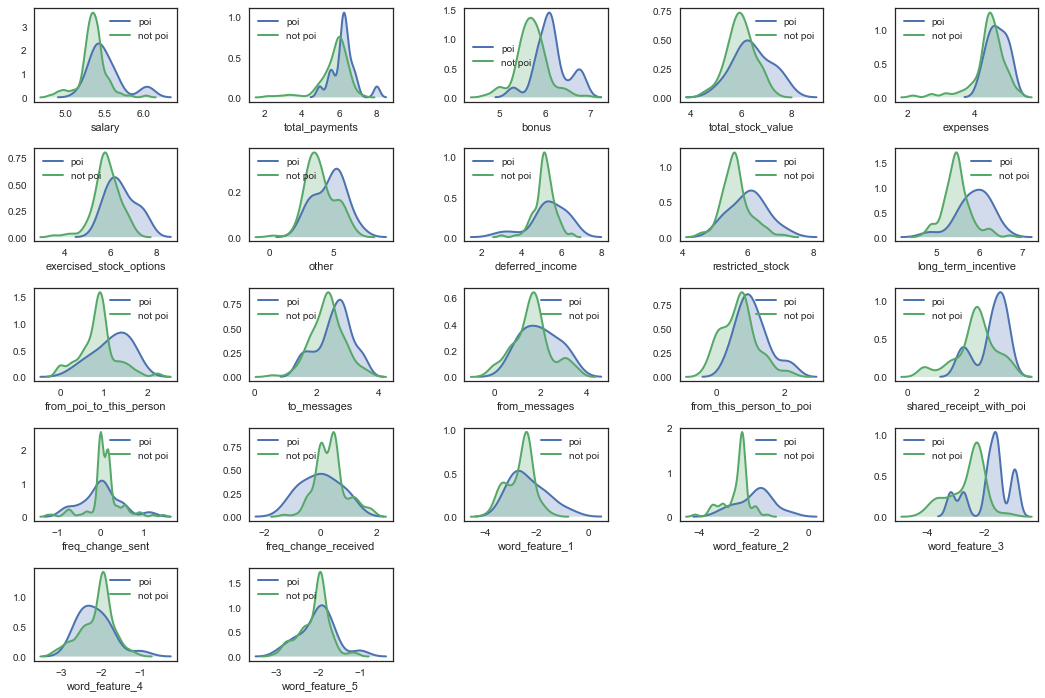

In [28]:
plt.figure(figsize=(18,12))
sns.set_style("white")
for idx,feature in enumerate(data_df.columns.drop("poi")):
    ax = plt.subplot(5, 5,idx+1)
    
    # transform to positive values for log10 transformation
    if feature == "deferred_income":
        feature_poi = np.log10(data_df[data_df["poi"]==True][feature]*-1)
        feature_regular = np.log10(data_df[data_df["poi"]==False][feature]*-1)
        
    else:
        feature_poi = np.log10(data_df[data_df["poi"]==True][feature])
        feature_regular = np.log10(data_df[data_df["poi"]==False][feature])
    
    label = ["poi", "not poi"]
    for idx, data_ in enumerate([feature_poi,feature_regular]) :
        sns.distplot(data_, hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 2}, label = label[idx])
    
plt.subplots_adjust(wspace=0.5, hspace=0.5) 

Training a support vector classifier with a selected feature set (6 of the highest scoring features with SelectKBest) and linear kernel further improved the classification performance. Both, precision and recall improved for the SVM classifier to 0.609 and 0.612, respectively. Overall, linear classifier exhibited again the best performance, of which SVM classifier exibits the best balanced score in terms of recall and precision. Next, I want to apply a systematical feature selection approach. Especially since both the dataset and total feature space are rather small, I will perform a sequential feature selection (combinatorial approach). Furthermore the results from the sequential feature selection will be compared to the dimensionality reduction approach via PCA.

In [107]:
clf = SVC(kernel = "linear", class_weight="balanced")
tester.dump_classifier_and_data(clf, final_dataset, ["poi","word_feature_2", "word_feature_3","exercised_stock_options","total_stock_value", "long_term_incentive", "bonus"])
tester.main()

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.89580	Precision: 0.60876	Recall: 0.61150	F1: 0.61013	F2: 0.61095
	Total predictions: 15000	True positives: 1223	False positives:  786	False negatives:  777	True negatives: 12214



**using selected features (linear kernel with SVC)**

|Classifier|Accuracy|Precision|Recall|
|---|---|---|
|SVC|0.896|0.609|0.612|
|Logistic Reg|0.862|0.487|0.650|
|Naive Bayes|0.875|0.534|0.470|
|DT|0.835|0.360|0.306|
|ADA|0.862|0.477|0.336|
|RF|0.880|0.631|0.232|

**Sequential Feature Selection**  

First of all features with a SelectKBest score below 3 will be removed from the feature set. Next, the aforementioned selection process will be a greedy approach by simply evaluating all possible feature combinations for each subset size (e.g., 3 features and subset size of 2 will result in following subsets: 12,13,23). For each subset size the best performing combination will be returned. I will use f1 score to evaluate the performance since I am interested in having a balanced prediction performance in terms of recall and precission.
Furthermore, StratifiedShuffleSplit with 20 reiterations of shuffling and resampling will be used to generate training and test sets.  
This is based on screening test scores for each fold for a random selection of "total-features-1" subsets using 5-fold StratifiedShuffleSplit. It is evident that there is a strong variation in test scores over the sets generated by StratifiedShuffleSplit. Since the dataset is very small, one would expect that training and test sets exhibit a rather smaller variation in datapoints. However, the strong variation in the fold-specific f1 scores is indicative of high variance in the dataset (and not necessarily predominantly between the two classes!!). of course this translates into a model with high variance!  
In order to account for high variance in the dataset and to being able to model a classifier with good prediction generalization (good prediction of unseen data) it is necessary train and test the classifier with as many as possible different data subsets (here, folds from StratifiedShuffleSplit). Especially in the context of selecting the best feature subset. This will make sure that the fold-specific test scores converge to the "true" test score for each feature combination, which helps to pinpoint each best subset combination.
Due to the greedy nature of this selection approach, there is a tradeoff between runtime performance and classification accuracy. The more folds used the more accurate the evaluation of each subset's classification performance but the more time the code requires to execute. I figured, 20 folds is a suitable size to be used in this feature selection approach.

In [23]:
# remove features with a SelectKBest score < 3 
to_remove = ['freq_change_sent','from_messages','word_feature_4','word_feature_5','to_messages','from_poi_to_this_person']
preselected_features = [item for item in feature_list_engineered if item not in to_remove]

With each smaller dimension the combinatorial space increases drastically, which of course increases very much the runtime of the code. As such, 5-feature dimension will be set as the lower cutoff.

In [ ]:
from feature_selection import *
clf = SVC(kernel = "linear", class_weight="balanced")
bfs = BFS(clf,final_dataset, preselected_features,5)
bfs.search()

pickle the best feature subset and the respective scores for each feature dimension

In [ ]:
with open("BFS_summary_20folds.pkl", "w") as file_out:
    pickle.dump(bfs.summary, file_out)

**summary sequential feature search (linear kernel with SVC)**

|subset dimension|Accuracy|Precision|Recall|
|---|---|---|
|16|0.777|0.299|0.501|
|15|0.784|0.320|0.551|
|14|0.786|0.324|0.559|
|10|0.876|0.534|0.550|
|9|0.888|0.577|0.607|
|8|0.894|0.600|0.604|
|7|0.900|0.623|0.627|
|6|0.895|0.604|0.613|
|5|0.895|0.598|0.652|

*best 7-subset feature set:*  
['bonus',
 'total_stock_value',
 'exercised_stock_options',
 'long_term_incentive',
 'freq_change_received',
 'word_feature_2',
 'word_feature_3']


Based on the results from sequential feature selection, the overall performance increases with decreasing number of features. The overall best performance is achieved with selected subset with 7 features. Interestingly, the selected subset contain 3 of the engineered features (tfidf features and email features) and 4 of the best financial features based on SelectKBest scoring. Feature selection further improved the prediction performance. However, I want to perform hyperparameter tuning to hopefully furthermore boost the prediction performance

**Hyperparameter Tuning**  
The best feature subset (sequential feature selection) will be used in combination with the previously evaluated best classifier (SVC) to facilitate the final optimization step.
Tuning will be conducted via GridSearch and similar to feature selection, I will use StratifiedShuffleSplit to account for high variance in the dataset. Since the overall time complexity is lower than in feature selection, I will use 500 folds with StratifiedShuffleSplit. I will ommit rbf kernel and poly kernel in grid search, since linear kernel resulted in best performance. Again, I figure this is a good tradeoff between runtime and model performance.

In [34]:
# filter the best subset (3, 4, 6, 10, 13, 15, 16) and add "poi" feature for correct data split
#final_features = np.array(preselected_features)[[3, 4, 6, 10, 13, 15, 16]]]
final_features = np.array(preselected_features)[[best_features[9]['best_subset_7']]]
final_features=list(final_features)
final_features.insert(0,"poi")

data = tester.featureFormat(final_dataset, final_features)
labels, features = tester.targetFeatureSplit(data)

In [17]:
parameters = {'clf__kernel':['linear'], 
              'clf__C':[0.01,0.2,0.4,0.8,1,2,4,8,10,100],
              "clf__gamma":[0.001,0.01,0.05, 0.1,1,10],
              "clf__class_weight":["balanced", {1:4,0:1},{1:5,0:1},{1:6,0:1}]}


pipeline = Pipeline([("clf", SVC())])

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=500,  random_state=42)
grid_search = GridSearchCV(pipeline, parameters, scoring = "f1", cv=cv)
grid_search.fit(features, labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=200, random_state=42, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__gamma': [0.001, 0.01, 0.05, 0.1, 1, 10], 'clf__C': [0.01, 0.2, 0.4, 0.8, 1, 2, 4, 8, 10, 100], 'clf__class_weight': ['balanced', {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 6}], 'clf__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [34]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('clf', SVC(C=0.4, cache_size=200, class_weight={0: 1, 1: 6}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [35]:
grid_search.best_score_

0.63916190476190482

In [60]:
tester.dump_classifier_and_data(grid_search.best_estimator_, final_dataset, final_features)
tester.main()

Pipeline(memory=None,
     steps=[('clf', SVC(C=0.4, cache_size=200, class_weight={0: 1, 1: 6}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.05, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.90867	Precision: 0.66475	Recall: 0.63550	F1: 0.64980	F2: 0.64114
	Total predictions: 15000	True positives: 1271	False positives:  641	False negatives:  729	True negatives: 12359



**optimized hyperparameter and best feature subset with SVC**

|Classifier|Accuracy|Precision|Recall|
|---|---|---|
|SVC|0.910|0.665|0.636|

Based on grid search, the best hyperparameter for the SVM classifier are: **C=0.4, class_weight={0: 1, 1: 6}, gamma=0.05.**  
This improves especially the precision score to 0. 665 (before, 0.623). Also the recall score increases from 0.627 to 0.636. Accuracy improves only slightly to 0.910 (before, 0.900).

# Conclusion
The final precision and recall scores are 0.665 and 0.636, respectively. Precision translates to all employees that were predicted by the model to be a person of interest approx. 67% of those predictions are correct and truly represent a person of interest (precision metric). The recall metric translates to approx. 64% of all persons of interest in the dataset were identified by the model.

If we break down the model building process using a support vector classifier, the precision improved significantly when the default feature set was expanded by the engineered features in combination with a linear kernel (from 0.279 to 0.370). Furthermore, a significant improvement in precision performance was achieved by selecting the best feature subset via greedy combinatorial search (from 0.370 to 0.623). However, this improvement comes at the cost of time it takes to execute the code and one has to decide if it is really worth the effort, or if alternative approaches can be applied to achieve similar results but at much more "user friendly" runtime. Frankly, I tested the SelectKBest algorithm in a grid search approach for feature selection, which resulted in precision and recall scores of 0.609 and 0.612 (6 best scoring features as the subset), respectively. However, the SelectKBest approach markedly reduced the overall time to perform feature selection. So obviously, one has to determine a rational timeframe for each project and decide on project basis whether longer runtime is a major issue for the success of the project.


As already mentioned in the section **Sequential Feature Selection**,  training a classifier with the main dataset  results in a high variance model, which exhibits markedly reduced predictive power when the model is applied to unseen test data. This is not very suprising if we take the small size of the main dataset and the number of missing datapoints into account. Furthermore, the small size of the dataset is rather restrictive in terms of optimizing the **bias-variance tradeoff**. Even with only 7 features selected, the model is relatively complex in comparison to the size of the dataset. In this context, using less features results in sacrificing predictive power. A prefered solution to reduce model variance without hampering predictive power would be to increase the number of training examples. We don't have more data on enron employees comprising of financial features. However, the size of the email corpus seems to offer enough training examples to train a classifier with much lower variance. The informtion enclosed within the email corpus has been aggregated in order to being able to merge with the main dataset. So effectively, we reduced the size of samples from >500,000 to 144, which again suggests that the classifier trained will suffer from high variance.     

As such, I assume that using exclusively the email corpus and the engineered TF-IDF values, respectively, to train the classifier will highly reduce model variance and concomitantly increase classification performance. So let's check this assumption.

### Classification based solely on TF-IDF values
Class labels will be assigned to email authors (from_data) in order to split the stemmed email dataset (word_data) into a train and test set. As already mentioned in the section "TF-IDF as a feature", 4250 emails out of 51919 emails in total, have been authored by poi employees. As such, I will use a stratified split method to preserve the class percentages in the train and test set.

In [8]:
class_label = pd.Series(from_data).apply(lambda x: data_df["poi"].loc[x])
feature_train, feature_test, label_train, label_test = train_test_split(word_data, class_label, test_size = 0.2,stratify=class_label, random_state = 1)

Next, the lower percentage class in the feature training set (poi class) will be upsampled to match the higher percentage class. It is important to perform upsampling after the train test split in order to avoid "carry over" of information from the training set into the test set, i.e. same upsampled features used for training and testing, which would cause overfitting.   

In [9]:
# reset indices of the class label Series and filter the dataset into poi and not-poi class
label_train = label_train.reset_index(drop=True)
poi_class, not_poi_class = label_train[label_train == True], label_train[label_train == False]

# upsample poi class; this will also duplicate indices of the poi class Series, which will be used to extract the 
# cognate features (word_data)
poi_class_upsampled = resample(poi_class, replace=True, n_samples = len(not_poi_class), random_state=1234)

# merge not-poi class with upsampled poi class and extract the corresponding features
label_train_upsampled = pd.concat([poi_class_upsampled, not_poi_class]).sample(frac=1) 
feature_train_upsampled = np.array(feature_train)[label_train_upsampled.index.values]

Transform the email training set into TF-IDF values and select the 15% TF-IDF values with best discriminative power between the two classes.

In [32]:
# hyperparameter based on hyperparameter tuning in section "TF-IDF values as features"
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df = 0.6, min_df=10)
feature_train_tdidf = vectorizer.fit_transform(feature_train_upsampled)

selector = SelectPercentile(percentile=10)
feature_train_tdidf_selected = selector.fit_transform(feature_train_tdidf, label_train_upsampled)

Perform transformation and selection for the feature test set

In [33]:
feature_test_tdidf = vectorizer.transform(feature_test)
feature_test_tdidf_selected = selector.transform(feature_test_tdidf)

Since this is not a comprehensive model selection and the feature space is high dimensional, I will only consider Decision Tree and Random Forrest.

In [44]:
classifier = {"Decision Tree":DT(), "Random Forrest":RF()}
scoring = {"Accuracy":accuracy_score, "Recall":recall_score, "Precision":precision_score}
for clf in classifier:
    clf_fitted = classifier[clf].fit(feature_train_tdidf_selected, label_train_upsampled)
    clf_predict = classifier[clf].predict(feature_test_tdidf_selected)
    for function in scoring:
        print clf, function, scoring[function](label_test, clf_predict)
        print "--------------------"

Random Forrest Recall 0.791764705882
--------------------
Random Forrest Precision 0.943899018233
--------------------
Random Forrest Accuracy 0.979102465331
--------------------
Decision Tree Recall 0.829411764706
--------------------
Decision Tree Precision 0.758880516685
--------------------
Decision Tree Accuracy 0.964464560863
--------------------


The classification results suggest that our hypothesis that model variance will be reduced whereas prediction power will be enhanced by increasing the effective sample size by three orders of magnitude is true. The improvement in comparison to the model trained with the main dataset (data_df) and engineered features is quite intriguing!! Random Forest exhibits an overall better performance. **Recall and precision improved by 25% and 42%, respectively!!** This is already a very satisfying result, however, let's see if we can boost the performance of the Random Forest classifier by facilitating hyperparameter tuning using grid search.

In [10]:
#convert upsampled training set into TF-IDF values and conduct grid_search
vectorizer = TfidfVectorizer(ngram_range = (1,1), max_df = 0.6, min_df=10)
feature_train_tdidf = vectorizer.fit_transform(feature_train_upsampled)

"""pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), max_df = 0.6, min_df=10)),
    ('tfidf', TfidfTransformer()),
    ('clf', RF()),
])"""

pipeline = Pipeline([
    ('clf', RF())
])

parameters = {
    'clf__criterion': ("gini", "entropy"),
    'clf__max_depth': (None, 10,100,500,1000),
    'clf__n_estimators': (10, 20, 40),
    'clf__min_samples_split': (2,4,6),
}

grid_search = GridSearchCV(pipeline, parameters, scoring="f1")
grid_search.fit(feature_train_tdidf, label_train_upsampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__criterion': ('gini', 'entropy'), 'clf__max_depth': (None, 10, 100, 500, 1000), 'clf__min_samples_split': (2, 4, 6), 'clf__n_estimators': (10, 20, 40)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [27]:
grid_search.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': None,
 'clf__min_samples_split': 4,
 'clf__n_estimators': 40}

In [31]:
clf = RF(criterion = 'entropy', max_depth= None, min_samples_split= 4,n_estimators= 40)
clf_fitted = clf.fit(feature_train_tdidf_selected, label_train_upsampled)
clf_predict = clf.predict(feature_test_tdidf_selected)

for function in scoring:
    print function, scoring[function](label_test, clf_predict)

Recall 0.792941176471
Precision 0.95197740113
Accuracy 0.979776579353


The performance improvement is negligible. It seems that classification performance of the Random Forest classifier already reached a plateau and further model optimization is not advisable. 